In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'balance_ratio' : 0.75,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_075_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(2629727, 828)
(2629727, 8)
validation
(311071, 828)
(311071, 8)
test
(385271, 828)
(385271, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/263 [..............................] - ETA: 7:09 - loss: 2.3735 - STD: 0.0806 - MAE: 0.2195

  4/263 [..............................] - ETA: 6s - loss: 2.1819 - STD: 0.0401 - MAE: 0.2191  

  7/263 [..............................] - ETA: 5s - loss: 2.1505 - STD: 0.0412 - MAE: 0.2185

 10/263 [>.............................] - ETA: 5s - loss: 2.1362 - STD: 0.0408 - MAE: 0.2183

 13/263 [>.............................] - ETA: 5s - loss: 2.1238 - STD: 0.0359 - MAE: 0.2184

 16/263 [>.............................] - ETA: 5s - loss: 2.1145 - STD: 0.0315 - MAE: 0.2184

 19/263 [=>............................] - ETA: 5s - loss: 2.1094 - STD: 0.0293 - MAE: 0.2184

 22/263 [=>............................] - ETA: 5s - loss: 2.1045 - STD: 0.0270 - MAE: 0.2184

 25/263 [=>............................] - ETA: 5s - loss: 2.0999 - STD: 0.0248 - MAE: 0.2184

 28/263 [==>...........................] - ETA: 5s - loss: 2.0953 - STD: 0.0238 - MAE: 0.2183

 31/263 [==>...........................] - ETA: 5s - loss: 2.0906 - STD: 0.0236 - MAE: 0.2182

 34/263 [==>...........................] - ETA: 5s - loss: 2.0852 - STD: 0.0234 - MAE: 0.2181

 37/263 [===>..........................] - ETA: 5s - loss: 2.0786 - STD: 0.0237 - MAE: 0.2179

 40/263 [===>..........................] - ETA: 5s - loss: 2.0710 - STD: 0.0246 - MAE: 0.2176

 43/263 [===>..........................] - ETA: 5s - loss: 2.0625 - STD: 0.0260 - MAE: 0.2172

 46/263 [====>.........................] - ETA: 4s - loss: 2.0532 - STD: 0.0277 - MAE: 0.2168

 49/263 [====>.........................] - ETA: 4s - loss: 2.0432 - STD: 0.0296 - MAE: 0.2164

 52/263 [====>.........................] - ETA: 4s - loss: 2.0331 - STD: 0.0316 - MAE: 0.2159

 55/263 [=====>........................] - ETA: 4s - loss: 2.0229 - STD: 0.0337 - MAE: 0.2154

 58/263 [=====>........................] - ETA: 4s - loss: 2.0128 - STD: 0.0358 - MAE: 0.2149

 61/263 [=====>........................] - ETA: 4s - loss: 2.0022 - STD: 0.0378 - MAE: 0.2144

 64/263 [======>.......................] - ETA: 4s - loss: 1.9916 - STD: 0.0399 - MAE: 0.2138

 67/263 [======>.......................] - ETA: 4s - loss: 1.9804 - STD: 0.0420 - MAE: 0.2132

 70/263 [======>.......................] - ETA: 4s - loss: 1.9684 - STD: 0.0440 - MAE: 0.2126

 73/263 [=======>......................] - ETA: 4s - loss: 1.9556 - STD: 0.0462 - MAE: 0.2119

 76/263 [=======>......................] - ETA: 4s - loss: 1.9419 - STD: 0.0484 - MAE: 0.2111

 79/263 [========>.....................] - ETA: 4s - loss: 1.9277 - STD: 0.0506 - MAE: 0.2104

 82/263 [========>.....................] - ETA: 4s - loss: 1.9129 - STD: 0.0530 - MAE: 0.2095

 85/263 [========>.....................] - ETA: 4s - loss: 1.8985 - STD: 0.0554 - MAE: 0.2087

 88/263 [=========>....................] - ETA: 3s - loss: 1.8844 - STD: 0.0577 - MAE: 0.2078

 91/263 [=========>....................] - ETA: 3s - loss: 1.8706 - STD: 0.0601 - MAE: 0.2069

 94/263 [=========>....................] - ETA: 3s - loss: 1.8574 - STD: 0.0624 - MAE: 0.2061

 97/263 [==========>...................] - ETA: 3s - loss: 1.8444 - STD: 0.0647 - MAE: 0.2053

100/263 [==========>...................] - ETA: 3s - loss: 1.8318 - STD: 0.0668 - MAE: 0.2044

103/263 [==========>...................] - ETA: 3s - loss: 1.8198 - STD: 0.0689 - MAE: 0.2037

106/263 [===========>..................] - ETA: 3s - loss: 1.8082 - STD: 0.0708 - MAE: 0.2029

109/263 [===========>..................] - ETA: 3s - loss: 1.7969 - STD: 0.0727 - MAE: 0.2021

112/263 [===========>..................] - ETA: 3s - loss: 1.7859 - STD: 0.0746 - MAE: 0.2014

115/263 [============>.................] - ETA: 3s - loss: 1.7751 - STD: 0.0764 - MAE: 0.2006

118/263 [============>.................] - ETA: 3s - loss: 1.7647 - STD: 0.0782 - MAE: 0.1999

121/263 [============>.................] - ETA: 3s - loss: 1.7550 - STD: 0.0800 - MAE: 0.1992

124/263 [=============>................] - ETA: 3s - loss: 1.7453 - STD: 0.0816 - MAE: 0.1985

127/263 [=============>................] - ETA: 3s - loss: 1.7361 - STD: 0.0833 - MAE: 0.1979

130/263 [=============>................] - ETA: 3s - loss: 1.7271 - STD: 0.0848 - MAE: 0.1972

133/263 [==============>...............] - ETA: 2s - loss: 1.7183 - STD: 0.0864 - MAE: 0.1966

135/263 [==============>...............] - ETA: 3s - loss: 1.7126 - STD: 0.0874 - MAE: 0.1962

138/263 [==============>...............] - ETA: 3s - loss: 1.7042 - STD: 0.0888 - MAE: 0.1956

141/263 [===============>..............] - ETA: 3s - loss: 1.6960 - STD: 0.0902 - MAE: 0.1949

144/263 [===============>..............] - ETA: 3s - loss: 1.6882 - STD: 0.0916 - MAE: 0.1944

147/263 [===============>..............] - ETA: 3s - loss: 1.6807 - STD: 0.0930 - MAE: 0.1938

150/263 [================>.............] - ETA: 3s - loss: 1.6733 - STD: 0.0943 - MAE: 0.1932

153/263 [================>.............] - ETA: 3s - loss: 1.6661 - STD: 0.0955 - MAE: 0.1927

156/263 [================>.............] - ETA: 3s - loss: 1.6590 - STD: 0.0968 - MAE: 0.1921

159/263 [=================>............] - ETA: 3s - loss: 1.6523 - STD: 0.0980 - MAE: 0.1916

162/263 [=================>............] - ETA: 2s - loss: 1.6454 - STD: 0.0992 - MAE: 0.1911

165/263 [=================>............] - ETA: 2s - loss: 1.6388 - STD: 0.1003 - MAE: 0.1906

168/263 [==================>...........] - ETA: 2s - loss: 1.6325 - STD: 0.1015 - MAE: 0.1901

171/263 [==================>...........] - ETA: 2s - loss: 1.6264 - STD: 0.1026 - MAE: 0.1896

174/263 [==================>...........] - ETA: 2s - loss: 1.6203 - STD: 0.1036 - MAE: 0.1891

177/263 [===================>..........] - ETA: 2s - loss: 1.6144 - STD: 0.1047 - MAE: 0.1887

180/263 [===================>..........] - ETA: 2s - loss: 1.6088 - STD: 0.1057 - MAE: 0.1882

183/263 [===================>..........] - ETA: 2s - loss: 1.6033 - STD: 0.1067 - MAE: 0.1878

186/263 [====================>.........] - ETA: 2s - loss: 1.5978 - STD: 0.1076 - MAE: 0.1874

189/263 [====================>.........] - ETA: 2s - loss: 1.5926 - STD: 0.1086 - MAE: 0.1869

192/263 [====================>.........] - ETA: 2s - loss: 1.5875 - STD: 0.1095 - MAE: 0.1865

195/263 [=====================>........] - ETA: 1s - loss: 1.5825 - STD: 0.1104 - MAE: 0.1861

198/263 [=====================>........] - ETA: 1s - loss: 1.5774 - STD: 0.1112 - MAE: 0.1857

201/263 [=====================>........] - ETA: 1s - loss: 1.5724 - STD: 0.1121 - MAE: 0.1853

204/263 [======================>.......] - ETA: 1s - loss: 1.5676 - STD: 0.1129 - MAE: 0.1849

207/263 [======================>.......] - ETA: 1s - loss: 1.5629 - STD: 0.1138 - MAE: 0.1846

210/263 [======================>.......] - ETA: 1s - loss: 1.5584 - STD: 0.1146 - MAE: 0.1842

213/263 [=======================>......] - ETA: 1s - loss: 1.5538 - STD: 0.1154 - MAE: 0.1838

216/263 [=======================>......] - ETA: 1s - loss: 1.5494 - STD: 0.1162 - MAE: 0.1835

219/263 [=======================>......] - ETA: 1s - loss: 1.5452 - STD: 0.1170 - MAE: 0.1831

222/263 [========================>.....] - ETA: 1s - loss: 1.5409 - STD: 0.1177 - MAE: 0.1827

225/263 [========================>.....] - ETA: 1s - loss: 1.5366 - STD: 0.1184 - MAE: 0.1824

228/263 [=========================>....] - ETA: 0s - loss: 1.5324 - STD: 0.1192 - MAE: 0.1820

231/263 [=========================>....] - ETA: 0s - loss: 1.5284 - STD: 0.1199 - MAE: 0.1817

234/263 [=========================>....] - ETA: 0s - loss: 1.5243 - STD: 0.1206 - MAE: 0.1814

237/263 [==========================>...] - ETA: 0s - loss: 1.5202 - STD: 0.1213 - MAE: 0.1810

240/263 [==========================>...] - ETA: 0s - loss: 1.5162 - STD: 0.1220 - MAE: 0.1807

243/263 [==========================>...] - ETA: 0s - loss: 1.5124 - STD: 0.1227 - MAE: 0.1804

246/263 [===========================>..] - ETA: 0s - loss: 1.5087 - STD: 0.1234 - MAE: 0.1800

249/263 [===========================>..] - ETA: 0s - loss: 1.5052 - STD: 0.1240 - MAE: 0.1797

252/263 [===========================>..] - ETA: 0s - loss: 1.5015 - STD: 0.1247 - MAE: 0.1794

255/263 [============================>.] - ETA: 0s - loss: 1.4980 - STD: 0.1253 - MAE: 0.1791

258/263 [============================>.] - ETA: 0s - loss: 1.4946 - STD: 0.1259 - MAE: 0.1788

261/263 [============================>.] - ETA: 0s - loss: 1.4912 - STD: 0.1265 - MAE: 0.1785

263/263 [==============================] - 10s 31ms/step - loss: 1.4890 - STD: 0.1269 - MAE: 0.1783 - val_loss: 1.2323 - val_STD: 0.1781 - val_MAE: 0.1527


Epoch 2/10000


  1/263 [..............................] - ETA: 13s - loss: 1.1916 - STD: 0.1790 - MAE: 0.1531

  4/263 [..............................] - ETA: 5s - loss: 1.1879 - STD: 0.1786 - MAE: 0.1529 

  7/263 [..............................] - ETA: 5s - loss: 1.1925 - STD: 0.1791 - MAE: 0.1529

 10/263 [>.............................] - ETA: 5s - loss: 1.1900 - STD: 0.1790 - MAE: 0.1527

 13/263 [>.............................] - ETA: 5s - loss: 1.1892 - STD: 0.1791 - MAE: 0.1527

 16/263 [>.............................] - ETA: 5s - loss: 1.1901 - STD: 0.1794 - MAE: 0.1527

 19/263 [=>............................] - ETA: 5s - loss: 1.1888 - STD: 0.1797 - MAE: 0.1525

 22/263 [=>............................] - ETA: 5s - loss: 1.1873 - STD: 0.1798 - MAE: 0.1524

 25/263 [=>............................] - ETA: 5s - loss: 1.1864 - STD: 0.1801 - MAE: 0.1522

 28/263 [==>...........................] - ETA: 5s - loss: 1.1852 - STD: 0.1803 - MAE: 0.1521

 31/263 [==>...........................] - ETA: 5s - loss: 1.1842 - STD: 0.1803 - MAE: 0.1520

 34/263 [==>...........................] - ETA: 5s - loss: 1.1827 - STD: 0.1805 - MAE: 0.1519

 37/263 [===>..........................] - ETA: 5s - loss: 1.1812 - STD: 0.1806 - MAE: 0.1518

 40/263 [===>..........................] - ETA: 5s - loss: 1.1811 - STD: 0.1807 - MAE: 0.1517

 43/263 [===>..........................] - ETA: 4s - loss: 1.1798 - STD: 0.1810 - MAE: 0.1516

 46/263 [====>.........................] - ETA: 4s - loss: 1.1788 - STD: 0.1812 - MAE: 0.1515

 49/263 [====>.........................] - ETA: 4s - loss: 1.1790 - STD: 0.1812 - MAE: 0.1514

 52/263 [====>.........................] - ETA: 4s - loss: 1.1781 - STD: 0.1812 - MAE: 0.1514

 55/263 [=====>........................] - ETA: 4s - loss: 1.1769 - STD: 0.1813 - MAE: 0.1513

 58/263 [=====>........................] - ETA: 4s - loss: 1.1753 - STD: 0.1815 - MAE: 0.1512

 61/263 [=====>........................] - ETA: 4s - loss: 1.1740 - STD: 0.1816 - MAE: 0.1510

 64/263 [======>.......................] - ETA: 4s - loss: 1.1721 - STD: 0.1817 - MAE: 0.1509

 67/263 [======>.......................] - ETA: 4s - loss: 1.1707 - STD: 0.1819 - MAE: 0.1508

 70/263 [======>.......................] - ETA: 4s - loss: 1.1695 - STD: 0.1821 - MAE: 0.1506

 73/263 [=======>......................] - ETA: 4s - loss: 1.1681 - STD: 0.1822 - MAE: 0.1505

 76/263 [=======>......................] - ETA: 4s - loss: 1.1668 - STD: 0.1824 - MAE: 0.1504

 79/263 [========>.....................] - ETA: 4s - loss: 1.1655 - STD: 0.1826 - MAE: 0.1502

 82/263 [========>.....................] - ETA: 4s - loss: 1.1646 - STD: 0.1827 - MAE: 0.1501

 85/263 [========>.....................] - ETA: 4s - loss: 1.1639 - STD: 0.1828 - MAE: 0.1500

 88/263 [=========>....................] - ETA: 3s - loss: 1.1627 - STD: 0.1830 - MAE: 0.1499

 91/263 [=========>....................] - ETA: 3s - loss: 1.1615 - STD: 0.1832 - MAE: 0.1498

 94/263 [=========>....................] - ETA: 3s - loss: 1.1609 - STD: 0.1833 - MAE: 0.1497

 97/263 [==========>...................] - ETA: 3s - loss: 1.1600 - STD: 0.1835 - MAE: 0.1496

100/263 [==========>...................] - ETA: 3s - loss: 1.1592 - STD: 0.1837 - MAE: 0.1495

103/263 [==========>...................] - ETA: 3s - loss: 1.1586 - STD: 0.1838 - MAE: 0.1494

106/263 [===========>..................] - ETA: 3s - loss: 1.1580 - STD: 0.1839 - MAE: 0.1493

109/263 [===========>..................] - ETA: 3s - loss: 1.1572 - STD: 0.1840 - MAE: 0.1492

112/263 [===========>..................] - ETA: 3s - loss: 1.1563 - STD: 0.1841 - MAE: 0.1491

115/263 [============>.................] - ETA: 3s - loss: 1.1554 - STD: 0.1843 - MAE: 0.1490

118/263 [============>.................] - ETA: 3s - loss: 1.1545 - STD: 0.1844 - MAE: 0.1489

121/263 [============>.................] - ETA: 3s - loss: 1.1535 - STD: 0.1845 - MAE: 0.1488

124/263 [=============>................] - ETA: 3s - loss: 1.1523 - STD: 0.1846 - MAE: 0.1487

127/263 [=============>................] - ETA: 3s - loss: 1.1511 - STD: 0.1847 - MAE: 0.1486

130/263 [=============>................] - ETA: 3s - loss: 1.1502 - STD: 0.1849 - MAE: 0.1485

133/263 [==============>...............] - ETA: 2s - loss: 1.1494 - STD: 0.1850 - MAE: 0.1484

136/263 [==============>...............] - ETA: 2s - loss: 1.1486 - STD: 0.1852 - MAE: 0.1483

139/263 [==============>...............] - ETA: 2s - loss: 1.1480 - STD: 0.1853 - MAE: 0.1482

142/263 [===============>..............] - ETA: 2s - loss: 1.1473 - STD: 0.1854 - MAE: 0.1482

145/263 [===============>..............] - ETA: 2s - loss: 1.1467 - STD: 0.1855 - MAE: 0.1481

148/263 [===============>..............] - ETA: 2s - loss: 1.1460 - STD: 0.1856 - MAE: 0.1480

151/263 [================>.............] - ETA: 2s - loss: 1.1454 - STD: 0.1857 - MAE: 0.1479

154/263 [================>.............] - ETA: 2s - loss: 1.1444 - STD: 0.1859 - MAE: 0.1478

157/263 [================>.............] - ETA: 2s - loss: 1.1438 - STD: 0.1860 - MAE: 0.1477

160/263 [=================>............] - ETA: 2s - loss: 1.1430 - STD: 0.1861 - MAE: 0.1476

163/263 [=================>............] - ETA: 2s - loss: 1.1421 - STD: 0.1862 - MAE: 0.1476

166/263 [=================>............] - ETA: 2s - loss: 1.1414 - STD: 0.1863 - MAE: 0.1475

169/263 [==================>...........] - ETA: 2s - loss: 1.1405 - STD: 0.1864 - MAE: 0.1474

172/263 [==================>...........] - ETA: 2s - loss: 1.1398 - STD: 0.1865 - MAE: 0.1473

175/263 [==================>...........] - ETA: 1s - loss: 1.1391 - STD: 0.1866 - MAE: 0.1472

178/263 [===================>..........] - ETA: 1s - loss: 1.1382 - STD: 0.1867 - MAE: 0.1471

181/263 [===================>..........] - ETA: 1s - loss: 1.1372 - STD: 0.1869 - MAE: 0.1470

184/263 [===================>..........] - ETA: 1s - loss: 1.1364 - STD: 0.1870 - MAE: 0.1469

187/263 [====================>.........] - ETA: 1s - loss: 1.1356 - STD: 0.1871 - MAE: 0.1468

190/263 [====================>.........] - ETA: 1s - loss: 1.1348 - STD: 0.1872 - MAE: 0.1468

193/263 [=====================>........] - ETA: 1s - loss: 1.1339 - STD: 0.1874 - MAE: 0.1467

196/263 [=====================>........] - ETA: 1s - loss: 1.1331 - STD: 0.1875 - MAE: 0.1466

199/263 [=====================>........] - ETA: 1s - loss: 1.1322 - STD: 0.1876 - MAE: 0.1465

202/263 [======================>.......] - ETA: 1s - loss: 1.1313 - STD: 0.1877 - MAE: 0.1464

205/263 [======================>.......] - ETA: 1s - loss: 1.1305 - STD: 0.1878 - MAE: 0.1463

208/263 [======================>.......] - ETA: 1s - loss: 1.1295 - STD: 0.1879 - MAE: 0.1462

211/263 [=======================>......] - ETA: 1s - loss: 1.1288 - STD: 0.1881 - MAE: 0.1461

214/263 [=======================>......] - ETA: 1s - loss: 1.1279 - STD: 0.1882 - MAE: 0.1460

217/263 [=======================>......] - ETA: 1s - loss: 1.1273 - STD: 0.1883 - MAE: 0.1459

220/263 [========================>.....] - ETA: 0s - loss: 1.1265 - STD: 0.1884 - MAE: 0.1458

223/263 [========================>.....] - ETA: 0s - loss: 1.1257 - STD: 0.1885 - MAE: 0.1458

226/263 [========================>.....] - ETA: 0s - loss: 1.1249 - STD: 0.1886 - MAE: 0.1457

229/263 [=========================>....] - ETA: 0s - loss: 1.1243 - STD: 0.1888 - MAE: 0.1456

232/263 [=========================>....] - ETA: 0s - loss: 1.1238 - STD: 0.1889 - MAE: 0.1455

235/263 [=========================>....] - ETA: 0s - loss: 1.1230 - STD: 0.1890 - MAE: 0.1454

238/263 [==========================>...] - ETA: 0s - loss: 1.1224 - STD: 0.1891 - MAE: 0.1454

241/263 [==========================>...] - ETA: 0s - loss: 1.1216 - STD: 0.1892 - MAE: 0.1453

244/263 [==========================>...] - ETA: 0s - loss: 1.1209 - STD: 0.1893 - MAE: 0.1452

247/263 [===========================>..] - ETA: 0s - loss: 1.1203 - STD: 0.1894 - MAE: 0.1451

250/263 [===========================>..] - ETA: 0s - loss: 1.1196 - STD: 0.1895 - MAE: 0.1450

253/263 [===========================>..] - ETA: 0s - loss: 1.1190 - STD: 0.1896 - MAE: 0.1450

256/263 [============================>.] - ETA: 0s - loss: 1.1184 - STD: 0.1897 - MAE: 0.1449

259/263 [============================>.] - ETA: 0s - loss: 1.1182 - STD: 0.1898 - MAE: 0.1448

262/263 [============================>.] - ETA: 0s - loss: 1.1176 - STD: 0.1899 - MAE: 0.1448

263/263 [==============================] - 7s 25ms/step - loss: 1.1173 - STD: 0.1900 - MAE: 0.1447 - val_loss: 1.1496 - val_STD: 0.1960 - val_MAE: 0.1411


Epoch 3/10000


  1/263 [..............................] - ETA: 13s - loss: 1.0404 - STD: 0.1985 - MAE: 0.1373

  3/263 [..............................] - ETA: 6s - loss: 1.0611 - STD: 0.1989 - MAE: 0.1381 

  6/263 [..............................] - ETA: 6s - loss: 1.0588 - STD: 0.1986 - MAE: 0.1381

  9/263 [>.............................] - ETA: 5s - loss: 1.0570 - STD: 0.1991 - MAE: 0.1378

 12/263 [>.............................] - ETA: 5s - loss: 1.0577 - STD: 0.1993 - MAE: 0.1378

 15/263 [>.............................] - ETA: 5s - loss: 1.0564 - STD: 0.1992 - MAE: 0.1377

 18/263 [=>............................] - ETA: 5s - loss: 1.0557 - STD: 0.1994 - MAE: 0.1376

 21/263 [=>............................] - ETA: 5s - loss: 1.0539 - STD: 0.1994 - MAE: 0.1375

 24/263 [=>............................] - ETA: 5s - loss: 1.0547 - STD: 0.1995 - MAE: 0.1376

 27/263 [==>...........................] - ETA: 5s - loss: 1.0565 - STD: 0.1996 - MAE: 0.1376

 30/263 [==>...........................] - ETA: 5s - loss: 1.0555 - STD: 0.1996 - MAE: 0.1376

 33/263 [==>...........................] - ETA: 5s - loss: 1.0560 - STD: 0.1997 - MAE: 0.1376

 36/263 [===>..........................] - ETA: 5s - loss: 1.0557 - STD: 0.1998 - MAE: 0.1375

 39/263 [===>..........................] - ETA: 5s - loss: 1.0551 - STD: 0.1997 - MAE: 0.1375

 42/263 [===>..........................] - ETA: 5s - loss: 1.0535 - STD: 0.1998 - MAE: 0.1374

 45/263 [====>.........................] - ETA: 4s - loss: 1.0526 - STD: 0.1999 - MAE: 0.1373

 48/263 [====>.........................] - ETA: 4s - loss: 1.0516 - STD: 0.1999 - MAE: 0.1373

 51/263 [====>.........................] - ETA: 4s - loss: 1.0507 - STD: 0.1999 - MAE: 0.1372

 54/263 [=====>........................] - ETA: 4s - loss: 1.0497 - STD: 0.2001 - MAE: 0.1371

 57/263 [=====>........................] - ETA: 4s - loss: 1.0494 - STD: 0.2002 - MAE: 0.1370

 60/263 [=====>........................] - ETA: 4s - loss: 1.0490 - STD: 0.2003 - MAE: 0.1369

 63/263 [======>.......................] - ETA: 4s - loss: 1.0482 - STD: 0.2004 - MAE: 0.1368

 66/263 [======>.......................] - ETA: 4s - loss: 1.0474 - STD: 0.2005 - MAE: 0.1368

 69/263 [======>.......................] - ETA: 4s - loss: 1.0471 - STD: 0.2006 - MAE: 0.1367

 72/263 [=======>......................] - ETA: 4s - loss: 1.0465 - STD: 0.2006 - MAE: 0.1367

 75/263 [=======>......................] - ETA: 4s - loss: 1.0461 - STD: 0.2007 - MAE: 0.1366

 78/263 [=======>......................] - ETA: 4s - loss: 1.0460 - STD: 0.2008 - MAE: 0.1366

 81/263 [========>.....................] - ETA: 4s - loss: 1.0455 - STD: 0.2008 - MAE: 0.1365

 84/263 [========>.....................] - ETA: 4s - loss: 1.0454 - STD: 0.2009 - MAE: 0.1365

 87/263 [========>.....................] - ETA: 3s - loss: 1.0449 - STD: 0.2009 - MAE: 0.1365

 90/263 [=========>....................] - ETA: 3s - loss: 1.0444 - STD: 0.2009 - MAE: 0.1364

 93/263 [=========>....................] - ETA: 3s - loss: 1.0437 - STD: 0.2010 - MAE: 0.1364

 96/263 [=========>....................] - ETA: 3s - loss: 1.0431 - STD: 0.2011 - MAE: 0.1363

 99/263 [==========>...................] - ETA: 3s - loss: 1.0427 - STD: 0.2012 - MAE: 0.1362

102/263 [==========>...................] - ETA: 3s - loss: 1.0421 - STD: 0.2012 - MAE: 0.1362

105/263 [==========>...................] - ETA: 3s - loss: 1.0414 - STD: 0.2013 - MAE: 0.1361

108/263 [===========>..................] - ETA: 3s - loss: 1.0408 - STD: 0.2014 - MAE: 0.1360

111/263 [===========>..................] - ETA: 3s - loss: 1.0401 - STD: 0.2014 - MAE: 0.1360

114/263 [============>.................] - ETA: 3s - loss: 1.0396 - STD: 0.2015 - MAE: 0.1359

117/263 [============>.................] - ETA: 3s - loss: 1.0392 - STD: 0.2016 - MAE: 0.1359

120/263 [============>.................] - ETA: 3s - loss: 1.0385 - STD: 0.2017 - MAE: 0.1358

123/263 [=============>................] - ETA: 3s - loss: 1.0382 - STD: 0.2017 - MAE: 0.1357

126/263 [=============>................] - ETA: 3s - loss: 1.0377 - STD: 0.2018 - MAE: 0.1357

129/263 [=============>................] - ETA: 3s - loss: 1.0380 - STD: 0.2019 - MAE: 0.1357

132/263 [==============>...............] - ETA: 2s - loss: 1.0374 - STD: 0.2019 - MAE: 0.1356

135/263 [==============>...............] - ETA: 2s - loss: 1.0369 - STD: 0.2020 - MAE: 0.1356

138/263 [==============>...............] - ETA: 2s - loss: 1.0363 - STD: 0.2021 - MAE: 0.1355

141/263 [===============>..............] - ETA: 2s - loss: 1.0360 - STD: 0.2021 - MAE: 0.1355

144/263 [===============>..............] - ETA: 2s - loss: 1.0356 - STD: 0.2022 - MAE: 0.1354

147/263 [===============>..............] - ETA: 2s - loss: 1.0357 - STD: 0.2023 - MAE: 0.1354

150/263 [================>.............] - ETA: 2s - loss: 1.0352 - STD: 0.2023 - MAE: 0.1353

153/263 [================>.............] - ETA: 2s - loss: 1.0353 - STD: 0.2023 - MAE: 0.1353

156/263 [================>.............] - ETA: 2s - loss: 1.0350 - STD: 0.2024 - MAE: 0.1353

159/263 [=================>............] - ETA: 2s - loss: 1.0343 - STD: 0.2024 - MAE: 0.1352

162/263 [=================>............] - ETA: 2s - loss: 1.0340 - STD: 0.2025 - MAE: 0.1352

165/263 [=================>............] - ETA: 2s - loss: 1.0336 - STD: 0.2026 - MAE: 0.1352

168/263 [==================>...........] - ETA: 2s - loss: 1.0337 - STD: 0.2026 - MAE: 0.1351

171/263 [==================>...........] - ETA: 2s - loss: 1.0332 - STD: 0.2027 - MAE: 0.1351

174/263 [==================>...........] - ETA: 2s - loss: 1.0330 - STD: 0.2028 - MAE: 0.1350

177/263 [===================>..........] - ETA: 1s - loss: 1.0326 - STD: 0.2028 - MAE: 0.1350

180/263 [===================>..........] - ETA: 1s - loss: 1.0323 - STD: 0.2029 - MAE: 0.1350

183/263 [===================>..........] - ETA: 1s - loss: 1.0322 - STD: 0.2029 - MAE: 0.1349

186/263 [====================>.........] - ETA: 1s - loss: 1.0319 - STD: 0.2030 - MAE: 0.1349

189/263 [====================>.........] - ETA: 1s - loss: 1.0319 - STD: 0.2030 - MAE: 0.1349

192/263 [====================>.........] - ETA: 1s - loss: 1.0319 - STD: 0.2031 - MAE: 0.1348

195/263 [=====================>........] - ETA: 1s - loss: 1.0319 - STD: 0.2031 - MAE: 0.1348

198/263 [=====================>........] - ETA: 1s - loss: 1.0315 - STD: 0.2031 - MAE: 0.1348

201/263 [=====================>........] - ETA: 1s - loss: 1.0312 - STD: 0.2032 - MAE: 0.1348

204/263 [======================>.......] - ETA: 1s - loss: 1.0308 - STD: 0.2032 - MAE: 0.1347

207/263 [======================>.......] - ETA: 1s - loss: 1.0305 - STD: 0.2032 - MAE: 0.1347

210/263 [======================>.......] - ETA: 1s - loss: 1.0302 - STD: 0.2033 - MAE: 0.1347

213/263 [=======================>......] - ETA: 1s - loss: 1.0298 - STD: 0.2033 - MAE: 0.1346

216/263 [=======================>......] - ETA: 1s - loss: 1.0294 - STD: 0.2033 - MAE: 0.1346

219/263 [=======================>......] - ETA: 0s - loss: 1.0289 - STD: 0.2034 - MAE: 0.1345

222/263 [========================>.....] - ETA: 0s - loss: 1.0283 - STD: 0.2034 - MAE: 0.1345

225/263 [========================>.....] - ETA: 0s - loss: 1.0278 - STD: 0.2035 - MAE: 0.1344

228/263 [=========================>....] - ETA: 0s - loss: 1.0273 - STD: 0.2035 - MAE: 0.1344

231/263 [=========================>....] - ETA: 0s - loss: 1.0269 - STD: 0.2036 - MAE: 0.1343

234/263 [=========================>....] - ETA: 0s - loss: 1.0267 - STD: 0.2037 - MAE: 0.1343

237/263 [==========================>...] - ETA: 0s - loss: 1.0264 - STD: 0.2037 - MAE: 0.1343

240/263 [==========================>...] - ETA: 0s - loss: 1.0266 - STD: 0.2038 - MAE: 0.1342

243/263 [==========================>...] - ETA: 0s - loss: 1.0262 - STD: 0.2038 - MAE: 0.1342

246/263 [===========================>..] - ETA: 0s - loss: 1.0257 - STD: 0.2039 - MAE: 0.1342

249/263 [===========================>..] - ETA: 0s - loss: 1.0252 - STD: 0.2039 - MAE: 0.1341

252/263 [===========================>..] - ETA: 0s - loss: 1.0247 - STD: 0.2040 - MAE: 0.1341

255/263 [============================>.] - ETA: 0s - loss: 1.0242 - STD: 0.2040 - MAE: 0.1340

258/263 [============================>.] - ETA: 0s - loss: 1.0237 - STD: 0.2041 - MAE: 0.1339

261/263 [============================>.] - ETA: 0s - loss: 1.0233 - STD: 0.2041 - MAE: 0.1339

263/263 [==============================] - 7s 25ms/step - loss: 1.0229 - STD: 0.2042 - MAE: 0.1339 - val_loss: 1.1062 - val_STD: 0.2059 - val_MAE: 0.1338


Epoch 4/10000


  1/263 [..............................] - ETA: 13s - loss: 0.9822 - STD: 0.2076 - MAE: 0.1300

  4/263 [..............................] - ETA: 5s - loss: 0.9821 - STD: 0.2083 - MAE: 0.1297 

  7/263 [..............................] - ETA: 5s - loss: 0.9828 - STD: 0.2087 - MAE: 0.1297

 10/263 [>.............................] - ETA: 5s - loss: 0.9804 - STD: 0.2088 - MAE: 0.1295

 13/263 [>.............................] - ETA: 5s - loss: 0.9838 - STD: 0.2089 - MAE: 0.1297

 16/263 [>.............................] - ETA: 5s - loss: 0.9849 - STD: 0.2089 - MAE: 0.1297

 19/263 [=>............................] - ETA: 5s - loss: 0.9839 - STD: 0.2091 - MAE: 0.1296

 22/263 [=>............................] - ETA: 5s - loss: 0.9819 - STD: 0.2091 - MAE: 0.1294

 25/263 [=>............................] - ETA: 5s - loss: 0.9828 - STD: 0.2093 - MAE: 0.1294

 28/263 [==>...........................] - ETA: 5s - loss: 0.9816 - STD: 0.2093 - MAE: 0.1293

 31/263 [==>...........................] - ETA: 5s - loss: 0.9822 - STD: 0.2094 - MAE: 0.1294

 34/263 [==>...........................] - ETA: 5s - loss: 0.9828 - STD: 0.2094 - MAE: 0.1294

 37/263 [===>..........................] - ETA: 5s - loss: 0.9818 - STD: 0.2095 - MAE: 0.1293

 40/263 [===>..........................] - ETA: 5s - loss: 0.9833 - STD: 0.2096 - MAE: 0.1293

 43/263 [===>..........................] - ETA: 4s - loss: 0.9832 - STD: 0.2097 - MAE: 0.1293

 46/263 [====>.........................] - ETA: 4s - loss: 0.9843 - STD: 0.2097 - MAE: 0.1293

 49/263 [====>.........................] - ETA: 4s - loss: 0.9835 - STD: 0.2098 - MAE: 0.1293

 52/263 [====>.........................] - ETA: 4s - loss: 0.9825 - STD: 0.2098 - MAE: 0.1292

 55/263 [=====>........................] - ETA: 4s - loss: 0.9818 - STD: 0.2098 - MAE: 0.1291

 58/263 [=====>........................] - ETA: 4s - loss: 0.9813 - STD: 0.2098 - MAE: 0.1291

 61/263 [=====>........................] - ETA: 4s - loss: 0.9810 - STD: 0.2098 - MAE: 0.1291

 64/263 [======>.......................] - ETA: 4s - loss: 0.9802 - STD: 0.2099 - MAE: 0.1290

 67/263 [======>.......................] - ETA: 4s - loss: 0.9796 - STD: 0.2099 - MAE: 0.1290

 70/263 [======>.......................] - ETA: 4s - loss: 0.9793 - STD: 0.2099 - MAE: 0.1289

 73/263 [=======>......................] - ETA: 4s - loss: 0.9791 - STD: 0.2099 - MAE: 0.1289

 76/263 [=======>......................] - ETA: 4s - loss: 0.9784 - STD: 0.2100 - MAE: 0.1289

 79/263 [========>.....................] - ETA: 4s - loss: 0.9781 - STD: 0.2100 - MAE: 0.1288

 82/263 [========>.....................] - ETA: 4s - loss: 0.9804 - STD: 0.2101 - MAE: 0.1289

 85/263 [========>.....................] - ETA: 4s - loss: 0.9806 - STD: 0.2102 - MAE: 0.1289

 88/263 [=========>....................] - ETA: 3s - loss: 0.9811 - STD: 0.2102 - MAE: 0.1289

 91/263 [=========>....................] - ETA: 3s - loss: 0.9812 - STD: 0.2102 - MAE: 0.1289

 94/263 [=========>....................] - ETA: 3s - loss: 0.9809 - STD: 0.2102 - MAE: 0.1289

 97/263 [==========>...................] - ETA: 3s - loss: 0.9806 - STD: 0.2102 - MAE: 0.1289

100/263 [==========>...................] - ETA: 3s - loss: 0.9796 - STD: 0.2103 - MAE: 0.1288

103/263 [==========>...................] - ETA: 3s - loss: 0.9793 - STD: 0.2103 - MAE: 0.1288

106/263 [===========>..................] - ETA: 3s - loss: 0.9788 - STD: 0.2103 - MAE: 0.1288

109/263 [===========>..................] - ETA: 3s - loss: 0.9786 - STD: 0.2103 - MAE: 0.1287

112/263 [===========>..................] - ETA: 3s - loss: 0.9785 - STD: 0.2104 - MAE: 0.1287

115/263 [============>.................] - ETA: 3s - loss: 0.9781 - STD: 0.2104 - MAE: 0.1287

118/263 [============>.................] - ETA: 3s - loss: 0.9774 - STD: 0.2105 - MAE: 0.1286

121/263 [============>.................] - ETA: 3s - loss: 0.9779 - STD: 0.2106 - MAE: 0.1286

124/263 [=============>................] - ETA: 3s - loss: 0.9786 - STD: 0.2106 - MAE: 0.1286

127/263 [=============>................] - ETA: 3s - loss: 0.9788 - STD: 0.2107 - MAE: 0.1286

130/263 [=============>................] - ETA: 3s - loss: 0.9790 - STD: 0.2107 - MAE: 0.1286

133/263 [==============>...............] - ETA: 2s - loss: 0.9790 - STD: 0.2107 - MAE: 0.1286

136/263 [==============>...............] - ETA: 2s - loss: 0.9794 - STD: 0.2107 - MAE: 0.1286

139/263 [==============>...............] - ETA: 2s - loss: 0.9795 - STD: 0.2108 - MAE: 0.1286

142/263 [===============>..............] - ETA: 2s - loss: 0.9792 - STD: 0.2108 - MAE: 0.1286

145/263 [===============>..............] - ETA: 2s - loss: 0.9791 - STD: 0.2108 - MAE: 0.1286

148/263 [===============>..............] - ETA: 2s - loss: 0.9788 - STD: 0.2108 - MAE: 0.1286

151/263 [================>.............] - ETA: 2s - loss: 0.9785 - STD: 0.2108 - MAE: 0.1285

154/263 [================>.............] - ETA: 2s - loss: 0.9780 - STD: 0.2108 - MAE: 0.1285

157/263 [================>.............] - ETA: 2s - loss: 0.9778 - STD: 0.2108 - MAE: 0.1285

160/263 [=================>............] - ETA: 2s - loss: 0.9773 - STD: 0.2108 - MAE: 0.1284

163/263 [=================>............] - ETA: 2s - loss: 0.9768 - STD: 0.2109 - MAE: 0.1284

166/263 [=================>............] - ETA: 2s - loss: 0.9763 - STD: 0.2109 - MAE: 0.1284

169/263 [==================>...........] - ETA: 2s - loss: 0.9760 - STD: 0.2109 - MAE: 0.1283

172/263 [==================>...........] - ETA: 2s - loss: 0.9756 - STD: 0.2110 - MAE: 0.1283

175/263 [==================>...........] - ETA: 1s - loss: 0.9753 - STD: 0.2110 - MAE: 0.1283

178/263 [===================>..........] - ETA: 1s - loss: 0.9747 - STD: 0.2110 - MAE: 0.1282

181/263 [===================>..........] - ETA: 1s - loss: 0.9741 - STD: 0.2111 - MAE: 0.1282

184/263 [===================>..........] - ETA: 1s - loss: 0.9736 - STD: 0.2111 - MAE: 0.1281

187/263 [====================>.........] - ETA: 1s - loss: 0.9731 - STD: 0.2112 - MAE: 0.1281

190/263 [====================>.........] - ETA: 1s - loss: 0.9727 - STD: 0.2112 - MAE: 0.1280

193/263 [=====================>........] - ETA: 1s - loss: 0.9726 - STD: 0.2113 - MAE: 0.1280

196/263 [=====================>........] - ETA: 1s - loss: 0.9727 - STD: 0.2113 - MAE: 0.1280

199/263 [=====================>........] - ETA: 1s - loss: 0.9723 - STD: 0.2113 - MAE: 0.1279

202/263 [======================>.......] - ETA: 1s - loss: 0.9720 - STD: 0.2114 - MAE: 0.1279

205/263 [======================>.......] - ETA: 1s - loss: 0.9715 - STD: 0.2114 - MAE: 0.1279

208/263 [======================>.......] - ETA: 1s - loss: 0.9709 - STD: 0.2114 - MAE: 0.1278

211/263 [=======================>......] - ETA: 1s - loss: 0.9707 - STD: 0.2115 - MAE: 0.1278

214/263 [=======================>......] - ETA: 1s - loss: 0.9705 - STD: 0.2115 - MAE: 0.1278

217/263 [=======================>......] - ETA: 1s - loss: 0.9703 - STD: 0.2116 - MAE: 0.1277

220/263 [========================>.....] - ETA: 0s - loss: 0.9702 - STD: 0.2116 - MAE: 0.1277

223/263 [========================>.....] - ETA: 0s - loss: 0.9699 - STD: 0.2117 - MAE: 0.1277

226/263 [========================>.....] - ETA: 0s - loss: 0.9695 - STD: 0.2117 - MAE: 0.1276

229/263 [=========================>....] - ETA: 0s - loss: 0.9694 - STD: 0.2117 - MAE: 0.1276

232/263 [=========================>....] - ETA: 0s - loss: 0.9692 - STD: 0.2118 - MAE: 0.1276

235/263 [=========================>....] - ETA: 0s - loss: 0.9690 - STD: 0.2118 - MAE: 0.1275

238/263 [==========================>...] - ETA: 0s - loss: 0.9686 - STD: 0.2118 - MAE: 0.1275

241/263 [==========================>...] - ETA: 0s - loss: 0.9684 - STD: 0.2119 - MAE: 0.1275

244/263 [==========================>...] - ETA: 0s - loss: 0.9684 - STD: 0.2119 - MAE: 0.1275

247/263 [===========================>..] - ETA: 0s - loss: 0.9685 - STD: 0.2120 - MAE: 0.1275

250/263 [===========================>..] - ETA: 0s - loss: 0.9682 - STD: 0.2120 - MAE: 0.1274

253/263 [===========================>..] - ETA: 0s - loss: 0.9678 - STD: 0.2120 - MAE: 0.1274

256/263 [============================>.] - ETA: 0s - loss: 0.9680 - STD: 0.2121 - MAE: 0.1274

259/263 [============================>.] - ETA: 0s - loss: 0.9678 - STD: 0.2121 - MAE: 0.1274

262/263 [============================>.] - ETA: 0s - loss: 0.9677 - STD: 0.2122 - MAE: 0.1273

263/263 [==============================] - 7s 25ms/step - loss: 0.9675 - STD: 0.2122 - MAE: 0.1273 - val_loss: 1.0515 - val_STD: 0.2120 - val_MAE: 0.1295


Epoch 5/10000


  1/263 [..............................] - ETA: 13s - loss: 0.9398 - STD: 0.2150 - MAE: 0.1240

  4/263 [..............................] - ETA: 6s - loss: 0.9435 - STD: 0.2149 - MAE: 0.1247 

  7/263 [..............................] - ETA: 5s - loss: 0.9454 - STD: 0.2152 - MAE: 0.1247

 10/263 [>.............................] - ETA: 5s - loss: 0.9440 - STD: 0.2151 - MAE: 0.1246

 13/263 [>.............................] - ETA: 5s - loss: 0.9435 - STD: 0.2151 - MAE: 0.1246

 16/263 [>.............................] - ETA: 5s - loss: 0.9440 - STD: 0.2149 - MAE: 0.1247

 19/263 [=>............................] - ETA: 5s - loss: 0.9427 - STD: 0.2148 - MAE: 0.1247

 22/263 [=>............................] - ETA: 5s - loss: 0.9427 - STD: 0.2149 - MAE: 0.1246

 25/263 [=>............................] - ETA: 5s - loss: 0.9423 - STD: 0.2149 - MAE: 0.1246

 28/263 [==>...........................] - ETA: 5s - loss: 0.9421 - STD: 0.2150 - MAE: 0.1245

 31/263 [==>...........................] - ETA: 5s - loss: 0.9442 - STD: 0.2150 - MAE: 0.1246

 34/263 [==>...........................] - ETA: 5s - loss: 0.9440 - STD: 0.2151 - MAE: 0.1246

 37/263 [===>..........................] - ETA: 5s - loss: 0.9453 - STD: 0.2152 - MAE: 0.1246

 40/263 [===>..........................] - ETA: 5s - loss: 0.9452 - STD: 0.2153 - MAE: 0.1246

 43/263 [===>..........................] - ETA: 4s - loss: 0.9461 - STD: 0.2153 - MAE: 0.1246

 46/263 [====>.........................] - ETA: 4s - loss: 0.9460 - STD: 0.2154 - MAE: 0.1246

 49/263 [====>.........................] - ETA: 4s - loss: 0.9461 - STD: 0.2153 - MAE: 0.1246

 52/263 [====>.........................] - ETA: 4s - loss: 0.9449 - STD: 0.2154 - MAE: 0.1245

 55/263 [=====>........................] - ETA: 4s - loss: 0.9444 - STD: 0.2154 - MAE: 0.1245

 58/263 [=====>........................] - ETA: 4s - loss: 0.9449 - STD: 0.2155 - MAE: 0.1245

 61/263 [=====>........................] - ETA: 4s - loss: 0.9446 - STD: 0.2155 - MAE: 0.1245

 64/263 [======>.......................] - ETA: 4s - loss: 0.9447 - STD: 0.2155 - MAE: 0.1245

 67/263 [======>.......................] - ETA: 4s - loss: 0.9444 - STD: 0.2155 - MAE: 0.1245

 70/263 [======>.......................] - ETA: 4s - loss: 0.9450 - STD: 0.2156 - MAE: 0.1245

 73/263 [=======>......................] - ETA: 4s - loss: 0.9451 - STD: 0.2156 - MAE: 0.1245

 76/263 [=======>......................] - ETA: 4s - loss: 0.9448 - STD: 0.2156 - MAE: 0.1245

 79/263 [========>.....................] - ETA: 4s - loss: 0.9452 - STD: 0.2157 - MAE: 0.1245

 82/263 [========>.....................] - ETA: 4s - loss: 0.9451 - STD: 0.2157 - MAE: 0.1245

 85/263 [========>.....................] - ETA: 4s - loss: 0.9449 - STD: 0.2157 - MAE: 0.1245

 88/263 [=========>....................] - ETA: 3s - loss: 0.9445 - STD: 0.2157 - MAE: 0.1244

 91/263 [=========>....................] - ETA: 3s - loss: 0.9438 - STD: 0.2157 - MAE: 0.1244

 94/263 [=========>....................] - ETA: 3s - loss: 0.9430 - STD: 0.2157 - MAE: 0.1243

 97/263 [==========>...................] - ETA: 3s - loss: 0.9421 - STD: 0.2158 - MAE: 0.1243

100/263 [==========>...................] - ETA: 3s - loss: 0.9416 - STD: 0.2158 - MAE: 0.1242

103/263 [==========>...................] - ETA: 3s - loss: 0.9414 - STD: 0.2158 - MAE: 0.1242

106/263 [===========>..................] - ETA: 3s - loss: 0.9407 - STD: 0.2159 - MAE: 0.1241

109/263 [===========>..................] - ETA: 3s - loss: 0.9401 - STD: 0.2159 - MAE: 0.1241

112/263 [===========>..................] - ETA: 3s - loss: 0.9395 - STD: 0.2159 - MAE: 0.1240

115/263 [============>.................] - ETA: 3s - loss: 0.9388 - STD: 0.2159 - MAE: 0.1240

118/263 [============>.................] - ETA: 3s - loss: 0.9382 - STD: 0.2160 - MAE: 0.1239

121/263 [============>.................] - ETA: 3s - loss: 0.9378 - STD: 0.2160 - MAE: 0.1239

124/263 [=============>................] - ETA: 3s - loss: 0.9374 - STD: 0.2161 - MAE: 0.1238

127/263 [=============>................] - ETA: 3s - loss: 0.9369 - STD: 0.2161 - MAE: 0.1238

130/263 [=============>................] - ETA: 3s - loss: 0.9365 - STD: 0.2161 - MAE: 0.1238

133/263 [==============>...............] - ETA: 2s - loss: 0.9361 - STD: 0.2162 - MAE: 0.1237

136/263 [==============>...............] - ETA: 2s - loss: 0.9356 - STD: 0.2162 - MAE: 0.1237

139/263 [==============>...............] - ETA: 2s - loss: 0.9351 - STD: 0.2163 - MAE: 0.1236

142/263 [===============>..............] - ETA: 2s - loss: 0.9346 - STD: 0.2163 - MAE: 0.1236

145/263 [===============>..............] - ETA: 2s - loss: 0.9340 - STD: 0.2164 - MAE: 0.1235

148/263 [===============>..............] - ETA: 2s - loss: 0.9338 - STD: 0.2164 - MAE: 0.1235

151/263 [================>.............] - ETA: 2s - loss: 0.9342 - STD: 0.2165 - MAE: 0.1235

154/263 [================>.............] - ETA: 2s - loss: 0.9345 - STD: 0.2165 - MAE: 0.1235

157/263 [================>.............] - ETA: 2s - loss: 0.9342 - STD: 0.2166 - MAE: 0.1234

160/263 [=================>............] - ETA: 2s - loss: 0.9339 - STD: 0.2166 - MAE: 0.1234

163/263 [=================>............] - ETA: 2s - loss: 0.9339 - STD: 0.2167 - MAE: 0.1234

166/263 [=================>............] - ETA: 2s - loss: 0.9337 - STD: 0.2167 - MAE: 0.1233

169/263 [==================>...........] - ETA: 2s - loss: 0.9334 - STD: 0.2167 - MAE: 0.1233

172/263 [==================>...........] - ETA: 2s - loss: 0.9330 - STD: 0.2168 - MAE: 0.1233

175/263 [==================>...........] - ETA: 1s - loss: 0.9328 - STD: 0.2168 - MAE: 0.1232

178/263 [===================>..........] - ETA: 1s - loss: 0.9323 - STD: 0.2169 - MAE: 0.1232

181/263 [===================>..........] - ETA: 1s - loss: 0.9319 - STD: 0.2169 - MAE: 0.1232

184/263 [===================>..........] - ETA: 1s - loss: 0.9313 - STD: 0.2169 - MAE: 0.1231

187/263 [====================>.........] - ETA: 1s - loss: 0.9310 - STD: 0.2169 - MAE: 0.1231

190/263 [====================>.........] - ETA: 1s - loss: 0.9308 - STD: 0.2170 - MAE: 0.1231

193/263 [=====================>........] - ETA: 1s - loss: 0.9304 - STD: 0.2170 - MAE: 0.1230

195/263 [=====================>........] - ETA: 1s - loss: 0.9302 - STD: 0.2170 - MAE: 0.1230

198/263 [=====================>........] - ETA: 1s - loss: 0.9299 - STD: 0.2171 - MAE: 0.1230

201/263 [=====================>........] - ETA: 1s - loss: 0.9295 - STD: 0.2171 - MAE: 0.1229

204/263 [======================>.......] - ETA: 1s - loss: 0.9291 - STD: 0.2171 - MAE: 0.1229

207/263 [======================>.......] - ETA: 1s - loss: 0.9287 - STD: 0.2172 - MAE: 0.1228

210/263 [======================>.......] - ETA: 1s - loss: 0.9284 - STD: 0.2172 - MAE: 0.1228

213/263 [=======================>......] - ETA: 1s - loss: 0.9292 - STD: 0.2173 - MAE: 0.1228

216/263 [=======================>......] - ETA: 1s - loss: 0.9298 - STD: 0.2173 - MAE: 0.1228

219/263 [=======================>......] - ETA: 0s - loss: 0.9309 - STD: 0.2174 - MAE: 0.1229

222/263 [========================>.....] - ETA: 0s - loss: 0.9312 - STD: 0.2174 - MAE: 0.1229

225/263 [========================>.....] - ETA: 0s - loss: 0.9314 - STD: 0.2174 - MAE: 0.1229

228/263 [=========================>....] - ETA: 0s - loss: 0.9315 - STD: 0.2174 - MAE: 0.1229

231/263 [=========================>....] - ETA: 0s - loss: 0.9320 - STD: 0.2174 - MAE: 0.1229

234/263 [=========================>....] - ETA: 0s - loss: 0.9321 - STD: 0.2175 - MAE: 0.1229

237/263 [==========================>...] - ETA: 0s - loss: 0.9321 - STD: 0.2175 - MAE: 0.1229

240/263 [==========================>...] - ETA: 0s - loss: 0.9321 - STD: 0.2175 - MAE: 0.1229

243/263 [==========================>...] - ETA: 0s - loss: 0.9320 - STD: 0.2175 - MAE: 0.1229

246/263 [===========================>..] - ETA: 0s - loss: 0.9319 - STD: 0.2175 - MAE: 0.1229

249/263 [===========================>..] - ETA: 0s - loss: 0.9317 - STD: 0.2175 - MAE: 0.1229

252/263 [===========================>..] - ETA: 0s - loss: 0.9314 - STD: 0.2175 - MAE: 0.1229

255/263 [============================>.] - ETA: 0s - loss: 0.9311 - STD: 0.2175 - MAE: 0.1228

258/263 [============================>.] - ETA: 0s - loss: 0.9307 - STD: 0.2175 - MAE: 0.1228

261/263 [============================>.] - ETA: 0s - loss: 0.9303 - STD: 0.2175 - MAE: 0.1228

263/263 [==============================] - 7s 25ms/step - loss: 0.9302 - STD: 0.2175 - MAE: 0.1228 - val_loss: 1.0575 - val_STD: 0.2168 - val_MAE: 0.1265


Epoch 6/10000


  1/263 [..............................] - ETA: 12s - loss: 0.8875 - STD: 0.2198 - MAE: 0.1192

  4/263 [..............................] - ETA: 6s - loss: 0.9033 - STD: 0.2192 - MAE: 0.1203 

  6/263 [..............................] - ETA: 6s - loss: 0.8991 - STD: 0.2194 - MAE: 0.1200

  9/263 [>.............................] - ETA: 6s - loss: 0.8985 - STD: 0.2195 - MAE: 0.1200

 12/263 [>.............................] - ETA: 5s - loss: 0.8981 - STD: 0.2197 - MAE: 0.1199

 15/263 [>.............................] - ETA: 5s - loss: 0.8975 - STD: 0.2197 - MAE: 0.1198

 18/263 [=>............................] - ETA: 5s - loss: 0.8992 - STD: 0.2199 - MAE: 0.1198

 21/263 [=>............................] - ETA: 5s - loss: 0.8993 - STD: 0.2200 - MAE: 0.1198

 24/263 [=>............................] - ETA: 5s - loss: 0.8986 - STD: 0.2202 - MAE: 0.1196

 27/263 [==>...........................] - ETA: 5s - loss: 0.8979 - STD: 0.2203 - MAE: 0.1196

 30/263 [==>...........................] - ETA: 5s - loss: 0.8970 - STD: 0.2203 - MAE: 0.1195

 33/263 [==>...........................] - ETA: 5s - loss: 0.8970 - STD: 0.2203 - MAE: 0.1195

 36/263 [===>..........................] - ETA: 5s - loss: 0.8974 - STD: 0.2205 - MAE: 0.1195

 39/263 [===>..........................] - ETA: 5s - loss: 0.8979 - STD: 0.2206 - MAE: 0.1194

 42/263 [===>..........................] - ETA: 5s - loss: 0.8989 - STD: 0.2206 - MAE: 0.1195

 45/263 [====>.........................] - ETA: 4s - loss: 0.8982 - STD: 0.2207 - MAE: 0.1194

 48/263 [====>.........................] - ETA: 4s - loss: 0.8979 - STD: 0.2207 - MAE: 0.1194

 51/263 [====>.........................] - ETA: 4s - loss: 0.8979 - STD: 0.2207 - MAE: 0.1194

 54/263 [=====>........................] - ETA: 4s - loss: 0.8987 - STD: 0.2207 - MAE: 0.1195

 57/263 [=====>........................] - ETA: 4s - loss: 0.8999 - STD: 0.2207 - MAE: 0.1195

 60/263 [=====>........................] - ETA: 4s - loss: 0.8999 - STD: 0.2207 - MAE: 0.1195

 63/263 [======>.......................] - ETA: 4s - loss: 0.9011 - STD: 0.2208 - MAE: 0.1196

 66/263 [======>.......................] - ETA: 4s - loss: 0.9008 - STD: 0.2208 - MAE: 0.1196

 69/263 [======>.......................] - ETA: 4s - loss: 0.9011 - STD: 0.2208 - MAE: 0.1196

 72/263 [=======>......................] - ETA: 4s - loss: 0.9014 - STD: 0.2208 - MAE: 0.1196

 75/263 [=======>......................] - ETA: 4s - loss: 0.9014 - STD: 0.2208 - MAE: 0.1196

 78/263 [=======>......................] - ETA: 4s - loss: 0.9018 - STD: 0.2209 - MAE: 0.1196

 81/263 [========>.....................] - ETA: 4s - loss: 0.9015 - STD: 0.2209 - MAE: 0.1196

 84/263 [========>.....................] - ETA: 4s - loss: 0.9014 - STD: 0.2208 - MAE: 0.1196

 87/263 [========>.....................] - ETA: 4s - loss: 0.9014 - STD: 0.2208 - MAE: 0.1196

 90/263 [=========>....................] - ETA: 3s - loss: 0.9009 - STD: 0.2208 - MAE: 0.1196

 93/263 [=========>....................] - ETA: 3s - loss: 0.9005 - STD: 0.2208 - MAE: 0.1195

 96/263 [=========>....................] - ETA: 3s - loss: 0.9001 - STD: 0.2208 - MAE: 0.1195

 99/263 [==========>...................] - ETA: 3s - loss: 0.9000 - STD: 0.2208 - MAE: 0.1195

102/263 [==========>...................] - ETA: 3s - loss: 0.8998 - STD: 0.2209 - MAE: 0.1195

105/263 [==========>...................] - ETA: 3s - loss: 0.8996 - STD: 0.2209 - MAE: 0.1194

108/263 [===========>..................] - ETA: 3s - loss: 0.8996 - STD: 0.2210 - MAE: 0.1194

110/263 [===========>..................] - ETA: 3s - loss: 0.8993 - STD: 0.2210 - MAE: 0.1194

113/263 [===========>..................] - ETA: 3s - loss: 0.8993 - STD: 0.2210 - MAE: 0.1194

116/263 [============>.................] - ETA: 3s - loss: 0.8995 - STD: 0.2211 - MAE: 0.1194

119/263 [============>.................] - ETA: 3s - loss: 0.8995 - STD: 0.2211 - MAE: 0.1194

122/263 [============>.................] - ETA: 3s - loss: 0.8991 - STD: 0.2211 - MAE: 0.1193

125/263 [=============>................] - ETA: 3s - loss: 0.8989 - STD: 0.2212 - MAE: 0.1193

128/263 [=============>................] - ETA: 3s - loss: 0.8986 - STD: 0.2212 - MAE: 0.1193

131/263 [=============>................] - ETA: 3s - loss: 0.8983 - STD: 0.2212 - MAE: 0.1192

134/263 [==============>...............] - ETA: 2s - loss: 0.8980 - STD: 0.2212 - MAE: 0.1192

137/263 [==============>...............] - ETA: 2s - loss: 0.8980 - STD: 0.2213 - MAE: 0.1192

140/263 [==============>...............] - ETA: 2s - loss: 0.8980 - STD: 0.2213 - MAE: 0.1192

143/263 [===============>..............] - ETA: 2s - loss: 0.8992 - STD: 0.2213 - MAE: 0.1192

146/263 [===============>..............] - ETA: 2s - loss: 0.8994 - STD: 0.2214 - MAE: 0.1192

149/263 [===============>..............] - ETA: 2s - loss: 0.9007 - STD: 0.2214 - MAE: 0.1193

152/263 [================>.............] - ETA: 2s - loss: 0.9008 - STD: 0.2214 - MAE: 0.1193

155/263 [================>.............] - ETA: 2s - loss: 0.9009 - STD: 0.2214 - MAE: 0.1193

158/263 [=================>............] - ETA: 2s - loss: 0.9008 - STD: 0.2214 - MAE: 0.1193

161/263 [=================>............] - ETA: 2s - loss: 0.9009 - STD: 0.2214 - MAE: 0.1193

164/263 [=================>............] - ETA: 2s - loss: 0.9008 - STD: 0.2215 - MAE: 0.1193

167/263 [==================>...........] - ETA: 2s - loss: 0.9007 - STD: 0.2214 - MAE: 0.1193

170/263 [==================>...........] - ETA: 2s - loss: 0.9005 - STD: 0.2215 - MAE: 0.1193

173/263 [==================>...........] - ETA: 2s - loss: 0.9001 - STD: 0.2215 - MAE: 0.1192

176/263 [===================>..........] - ETA: 1s - loss: 0.8999 - STD: 0.2215 - MAE: 0.1192

179/263 [===================>..........] - ETA: 1s - loss: 0.8997 - STD: 0.2215 - MAE: 0.1192

182/263 [===================>..........] - ETA: 1s - loss: 0.8996 - STD: 0.2215 - MAE: 0.1192

185/263 [====================>.........] - ETA: 1s - loss: 0.8994 - STD: 0.2215 - MAE: 0.1192

188/263 [====================>.........] - ETA: 1s - loss: 0.8992 - STD: 0.2215 - MAE: 0.1192

191/263 [====================>.........] - ETA: 1s - loss: 0.8988 - STD: 0.2215 - MAE: 0.1191

194/263 [=====================>........] - ETA: 1s - loss: 0.8983 - STD: 0.2216 - MAE: 0.1191

197/263 [=====================>........] - ETA: 1s - loss: 0.8981 - STD: 0.2216 - MAE: 0.1191

200/263 [=====================>........] - ETA: 1s - loss: 0.8979 - STD: 0.2216 - MAE: 0.1190

203/263 [======================>.......] - ETA: 1s - loss: 0.8978 - STD: 0.2216 - MAE: 0.1190

206/263 [======================>.......] - ETA: 1s - loss: 0.8976 - STD: 0.2217 - MAE: 0.1190

209/263 [======================>.......] - ETA: 1s - loss: 0.8972 - STD: 0.2217 - MAE: 0.1190

212/263 [=======================>......] - ETA: 1s - loss: 0.8969 - STD: 0.2217 - MAE: 0.1189

215/263 [=======================>......] - ETA: 1s - loss: 0.8966 - STD: 0.2217 - MAE: 0.1189

218/263 [=======================>......] - ETA: 1s - loss: 0.8963 - STD: 0.2217 - MAE: 0.1189

221/263 [========================>.....] - ETA: 0s - loss: 0.8961 - STD: 0.2218 - MAE: 0.1189

224/263 [========================>.....] - ETA: 0s - loss: 0.8958 - STD: 0.2218 - MAE: 0.1188

227/263 [========================>.....] - ETA: 0s - loss: 0.8954 - STD: 0.2218 - MAE: 0.1188

230/263 [=========================>....] - ETA: 0s - loss: 0.8952 - STD: 0.2219 - MAE: 0.1188

233/263 [=========================>....] - ETA: 0s - loss: 0.8949 - STD: 0.2219 - MAE: 0.1187

236/263 [=========================>....] - ETA: 0s - loss: 0.8947 - STD: 0.2219 - MAE: 0.1187

239/263 [==========================>...] - ETA: 0s - loss: 0.8947 - STD: 0.2219 - MAE: 0.1187

242/263 [==========================>...] - ETA: 0s - loss: 0.8947 - STD: 0.2220 - MAE: 0.1187

245/263 [==========================>...] - ETA: 0s - loss: 0.8948 - STD: 0.2220 - MAE: 0.1187

248/263 [===========================>..] - ETA: 0s - loss: 0.8949 - STD: 0.2220 - MAE: 0.1187

251/263 [===========================>..] - ETA: 0s - loss: 0.8948 - STD: 0.2221 - MAE: 0.1186

254/263 [===========================>..] - ETA: 0s - loss: 0.8947 - STD: 0.2221 - MAE: 0.1186

257/263 [============================>.] - ETA: 0s - loss: 0.8944 - STD: 0.2221 - MAE: 0.1186

260/263 [============================>.] - ETA: 0s - loss: 0.8943 - STD: 0.2221 - MAE: 0.1186

263/263 [==============================] - ETA: 0s - loss: 0.8941 - STD: 0.2221 - MAE: 0.1186

263/263 [==============================] - 7s 25ms/step - loss: 0.8941 - STD: 0.2221 - MAE: 0.1186 - val_loss: 1.0221 - val_STD: 0.2185 - val_MAE: 0.1246


Epoch 7/10000


  1/263 [..............................] - ETA: 13s - loss: 0.8785 - STD: 0.2229 - MAE: 0.1174

  4/263 [..............................] - ETA: 5s - loss: 0.8784 - STD: 0.2237 - MAE: 0.1169 

  7/263 [..............................] - ETA: 5s - loss: 0.8746 - STD: 0.2236 - MAE: 0.1167

 10/263 [>.............................] - ETA: 5s - loss: 0.8756 - STD: 0.2237 - MAE: 0.1167

 13/263 [>.............................] - ETA: 5s - loss: 0.8762 - STD: 0.2236 - MAE: 0.1168

 16/263 [>.............................] - ETA: 5s - loss: 0.8774 - STD: 0.2236 - MAE: 0.1169

 19/263 [=>............................] - ETA: 5s - loss: 0.8768 - STD: 0.2237 - MAE: 0.1168

 22/263 [=>............................] - ETA: 5s - loss: 0.8780 - STD: 0.2239 - MAE: 0.1168

 25/263 [=>............................] - ETA: 5s - loss: 0.8782 - STD: 0.2239 - MAE: 0.1168

 28/263 [==>...........................] - ETA: 5s - loss: 0.8783 - STD: 0.2240 - MAE: 0.1168

 31/263 [==>...........................] - ETA: 5s - loss: 0.8789 - STD: 0.2241 - MAE: 0.1168

 34/263 [==>...........................] - ETA: 5s - loss: 0.8798 - STD: 0.2241 - MAE: 0.1168

 37/263 [===>..........................] - ETA: 5s - loss: 0.8826 - STD: 0.2242 - MAE: 0.1169

 40/263 [===>..........................] - ETA: 5s - loss: 0.8825 - STD: 0.2242 - MAE: 0.1169

 43/263 [===>..........................] - ETA: 5s - loss: 0.8850 - STD: 0.2243 - MAE: 0.1170

 46/263 [====>.........................] - ETA: 4s - loss: 0.8859 - STD: 0.2243 - MAE: 0.1171

 49/263 [====>.........................] - ETA: 4s - loss: 0.8851 - STD: 0.2243 - MAE: 0.1170

 52/263 [====>.........................] - ETA: 4s - loss: 0.8842 - STD: 0.2243 - MAE: 0.1170

 55/263 [=====>........................] - ETA: 4s - loss: 0.8835 - STD: 0.2243 - MAE: 0.1169

 57/263 [=====>........................] - ETA: 4s - loss: 0.8840 - STD: 0.2243 - MAE: 0.1170

 59/263 [=====>........................] - ETA: 4s - loss: 0.8834 - STD: 0.2243 - MAE: 0.1169

 62/263 [======>.......................] - ETA: 4s - loss: 0.8829 - STD: 0.2243 - MAE: 0.1169

 64/263 [======>.......................] - ETA: 4s - loss: 0.8825 - STD: 0.2243 - MAE: 0.1169

 66/263 [======>.......................] - ETA: 4s - loss: 0.8822 - STD: 0.2242 - MAE: 0.1169

 69/263 [======>.......................] - ETA: 4s - loss: 0.8815 - STD: 0.2242 - MAE: 0.1169

 72/263 [=======>......................] - ETA: 4s - loss: 0.8806 - STD: 0.2242 - MAE: 0.1168

 75/263 [=======>......................] - ETA: 4s - loss: 0.8804 - STD: 0.2242 - MAE: 0.1168

 78/263 [=======>......................] - ETA: 4s - loss: 0.8802 - STD: 0.2243 - MAE: 0.1168

 81/263 [========>.....................] - ETA: 4s - loss: 0.8794 - STD: 0.2243 - MAE: 0.1167

 84/263 [========>.....................] - ETA: 4s - loss: 0.8791 - STD: 0.2243 - MAE: 0.1167

 87/263 [========>.....................] - ETA: 4s - loss: 0.8786 - STD: 0.2243 - MAE: 0.1166

 90/263 [=========>....................] - ETA: 4s - loss: 0.8784 - STD: 0.2243 - MAE: 0.1166

 93/263 [=========>....................] - ETA: 3s - loss: 0.8780 - STD: 0.2244 - MAE: 0.1166

 96/263 [=========>....................] - ETA: 3s - loss: 0.8780 - STD: 0.2244 - MAE: 0.1166

 99/263 [==========>...................] - ETA: 3s - loss: 0.8779 - STD: 0.2244 - MAE: 0.1165

102/263 [==========>...................] - ETA: 3s - loss: 0.8792 - STD: 0.2245 - MAE: 0.1166

105/263 [==========>...................] - ETA: 3s - loss: 0.8794 - STD: 0.2245 - MAE: 0.1166

108/263 [===========>..................] - ETA: 3s - loss: 0.8794 - STD: 0.2245 - MAE: 0.1166

111/263 [===========>..................] - ETA: 3s - loss: 0.8795 - STD: 0.2245 - MAE: 0.1166

114/263 [============>.................] - ETA: 3s - loss: 0.8797 - STD: 0.2245 - MAE: 0.1166

117/263 [============>.................] - ETA: 3s - loss: 0.8796 - STD: 0.2246 - MAE: 0.1166

120/263 [============>.................] - ETA: 3s - loss: 0.8794 - STD: 0.2246 - MAE: 0.1166

123/263 [=============>................] - ETA: 3s - loss: 0.8794 - STD: 0.2246 - MAE: 0.1166

126/263 [=============>................] - ETA: 3s - loss: 0.8795 - STD: 0.2246 - MAE: 0.1166

129/263 [=============>................] - ETA: 3s - loss: 0.8791 - STD: 0.2246 - MAE: 0.1165

132/263 [==============>...............] - ETA: 3s - loss: 0.8789 - STD: 0.2246 - MAE: 0.1165

135/263 [==============>...............] - ETA: 2s - loss: 0.8783 - STD: 0.2246 - MAE: 0.1165

138/263 [==============>...............] - ETA: 2s - loss: 0.8778 - STD: 0.2247 - MAE: 0.1164

141/263 [===============>..............] - ETA: 2s - loss: 0.8776 - STD: 0.2247 - MAE: 0.1164

144/263 [===============>..............] - ETA: 2s - loss: 0.8773 - STD: 0.2247 - MAE: 0.1164

147/263 [===============>..............] - ETA: 2s - loss: 0.8768 - STD: 0.2247 - MAE: 0.1163

150/263 [================>.............] - ETA: 2s - loss: 0.8763 - STD: 0.2248 - MAE: 0.1163

153/263 [================>.............] - ETA: 2s - loss: 0.8757 - STD: 0.2248 - MAE: 0.1163

156/263 [================>.............] - ETA: 2s - loss: 0.8752 - STD: 0.2248 - MAE: 0.1162

159/263 [=================>............] - ETA: 2s - loss: 0.8753 - STD: 0.2248 - MAE: 0.1162

162/263 [=================>............] - ETA: 2s - loss: 0.8764 - STD: 0.2249 - MAE: 0.1163

165/263 [=================>............] - ETA: 2s - loss: 0.8764 - STD: 0.2249 - MAE: 0.1162

168/263 [==================>...........] - ETA: 2s - loss: 0.8762 - STD: 0.2249 - MAE: 0.1162

171/263 [==================>...........] - ETA: 2s - loss: 0.8767 - STD: 0.2250 - MAE: 0.1162

174/263 [==================>...........] - ETA: 2s - loss: 0.8765 - STD: 0.2250 - MAE: 0.1162

177/263 [===================>..........] - ETA: 2s - loss: 0.8771 - STD: 0.2250 - MAE: 0.1162

180/263 [===================>..........] - ETA: 1s - loss: 0.8776 - STD: 0.2250 - MAE: 0.1163

183/263 [===================>..........] - ETA: 1s - loss: 0.8780 - STD: 0.2250 - MAE: 0.1163

186/263 [====================>.........] - ETA: 1s - loss: 0.8781 - STD: 0.2250 - MAE: 0.1163

189/263 [====================>.........] - ETA: 1s - loss: 0.8780 - STD: 0.2250 - MAE: 0.1163

192/263 [====================>.........] - ETA: 1s - loss: 0.8778 - STD: 0.2250 - MAE: 0.1163

195/263 [=====================>........] - ETA: 1s - loss: 0.8775 - STD: 0.2250 - MAE: 0.1163

198/263 [=====================>........] - ETA: 1s - loss: 0.8774 - STD: 0.2250 - MAE: 0.1163

201/263 [=====================>........] - ETA: 1s - loss: 0.8773 - STD: 0.2250 - MAE: 0.1163

204/263 [======================>.......] - ETA: 1s - loss: 0.8772 - STD: 0.2250 - MAE: 0.1162

207/263 [======================>.......] - ETA: 1s - loss: 0.8773 - STD: 0.2250 - MAE: 0.1163

210/263 [======================>.......] - ETA: 1s - loss: 0.8770 - STD: 0.2250 - MAE: 0.1162

213/263 [=======================>......] - ETA: 1s - loss: 0.8769 - STD: 0.2250 - MAE: 0.1162

216/263 [=======================>......] - ETA: 1s - loss: 0.8767 - STD: 0.2250 - MAE: 0.1162

219/263 [=======================>......] - ETA: 1s - loss: 0.8764 - STD: 0.2251 - MAE: 0.1162

222/263 [========================>.....] - ETA: 0s - loss: 0.8763 - STD: 0.2251 - MAE: 0.1162

225/263 [========================>.....] - ETA: 0s - loss: 0.8761 - STD: 0.2251 - MAE: 0.1161

228/263 [=========================>....] - ETA: 0s - loss: 0.8759 - STD: 0.2251 - MAE: 0.1161

231/263 [=========================>....] - ETA: 0s - loss: 0.8757 - STD: 0.2251 - MAE: 0.1161

234/263 [=========================>....] - ETA: 0s - loss: 0.8756 - STD: 0.2252 - MAE: 0.1161

237/263 [==========================>...] - ETA: 0s - loss: 0.8754 - STD: 0.2252 - MAE: 0.1161

240/263 [==========================>...] - ETA: 0s - loss: 0.8752 - STD: 0.2252 - MAE: 0.1160

243/263 [==========================>...] - ETA: 0s - loss: 0.8749 - STD: 0.2252 - MAE: 0.1160

246/263 [===========================>..] - ETA: 0s - loss: 0.8746 - STD: 0.2252 - MAE: 0.1160

249/263 [===========================>..] - ETA: 0s - loss: 0.8742 - STD: 0.2252 - MAE: 0.1160

252/263 [===========================>..] - ETA: 0s - loss: 0.8740 - STD: 0.2253 - MAE: 0.1159

255/263 [============================>.] - ETA: 0s - loss: 0.8737 - STD: 0.2253 - MAE: 0.1159

258/263 [============================>.] - ETA: 0s - loss: 0.8736 - STD: 0.2253 - MAE: 0.1159

261/263 [============================>.] - ETA: 0s - loss: 0.8733 - STD: 0.2253 - MAE: 0.1159

263/263 [==============================] - 7s 25ms/step - loss: 0.8732 - STD: 0.2253 - MAE: 0.1159 - val_loss: 1.0501 - val_STD: 0.2203 - val_MAE: 0.1243


Epoch 8/10000


  1/263 [..............................] - ETA: 13s - loss: 0.8586 - STD: 0.2262 - MAE: 0.1144

  4/263 [..............................] - ETA: 6s - loss: 0.8627 - STD: 0.2271 - MAE: 0.1144 

  7/263 [..............................] - ETA: 5s - loss: 0.8594 - STD: 0.2272 - MAE: 0.1141

 10/263 [>.............................] - ETA: 5s - loss: 0.8562 - STD: 0.2276 - MAE: 0.1137

 13/263 [>.............................] - ETA: 5s - loss: 0.8556 - STD: 0.2274 - MAE: 0.1138

 16/263 [>.............................] - ETA: 5s - loss: 0.8568 - STD: 0.2274 - MAE: 0.1139

 19/263 [=>............................] - ETA: 5s - loss: 0.8578 - STD: 0.2273 - MAE: 0.1140

 22/263 [=>............................] - ETA: 5s - loss: 0.8573 - STD: 0.2273 - MAE: 0.1140

 25/263 [=>............................] - ETA: 5s - loss: 0.8574 - STD: 0.2273 - MAE: 0.1140

 28/263 [==>...........................] - ETA: 5s - loss: 0.8569 - STD: 0.2273 - MAE: 0.1139

 31/263 [==>...........................] - ETA: 5s - loss: 0.8559 - STD: 0.2274 - MAE: 0.1138

 34/263 [==>...........................] - ETA: 5s - loss: 0.8576 - STD: 0.2274 - MAE: 0.1139

 37/263 [===>..........................] - ETA: 5s - loss: 0.8568 - STD: 0.2275 - MAE: 0.1138

 40/263 [===>..........................] - ETA: 5s - loss: 0.8564 - STD: 0.2275 - MAE: 0.1138

 43/263 [===>..........................] - ETA: 5s - loss: 0.8560 - STD: 0.2275 - MAE: 0.1138

 46/263 [====>.........................] - ETA: 4s - loss: 0.8568 - STD: 0.2275 - MAE: 0.1138

 49/263 [====>.........................] - ETA: 4s - loss: 0.8569 - STD: 0.2275 - MAE: 0.1138

 52/263 [====>.........................] - ETA: 4s - loss: 0.8572 - STD: 0.2275 - MAE: 0.1138

 55/263 [=====>........................] - ETA: 4s - loss: 0.8584 - STD: 0.2275 - MAE: 0.1139

 58/263 [=====>........................] - ETA: 4s - loss: 0.8584 - STD: 0.2275 - MAE: 0.1139

 61/263 [=====>........................] - ETA: 4s - loss: 0.8577 - STD: 0.2275 - MAE: 0.1139

 64/263 [======>.......................] - ETA: 4s - loss: 0.8569 - STD: 0.2275 - MAE: 0.1138

 67/263 [======>.......................] - ETA: 4s - loss: 0.8562 - STD: 0.2275 - MAE: 0.1138

 70/263 [======>.......................] - ETA: 4s - loss: 0.8553 - STD: 0.2275 - MAE: 0.1137

 73/263 [=======>......................] - ETA: 4s - loss: 0.8548 - STD: 0.2276 - MAE: 0.1137

 76/263 [=======>......................] - ETA: 4s - loss: 0.8541 - STD: 0.2276 - MAE: 0.1136

 79/263 [========>.....................] - ETA: 4s - loss: 0.8536 - STD: 0.2276 - MAE: 0.1136

 82/263 [========>.....................] - ETA: 4s - loss: 0.8532 - STD: 0.2277 - MAE: 0.1135

 85/263 [========>.....................] - ETA: 4s - loss: 0.8536 - STD: 0.2277 - MAE: 0.1135

 88/263 [=========>....................] - ETA: 3s - loss: 0.8534 - STD: 0.2277 - MAE: 0.1135

 91/263 [=========>....................] - ETA: 3s - loss: 0.8532 - STD: 0.2277 - MAE: 0.1135

 94/263 [=========>....................] - ETA: 3s - loss: 0.8529 - STD: 0.2277 - MAE: 0.1135

 97/263 [==========>...................] - ETA: 3s - loss: 0.8525 - STD: 0.2278 - MAE: 0.1134

100/263 [==========>...................] - ETA: 3s - loss: 0.8521 - STD: 0.2278 - MAE: 0.1134

103/263 [==========>...................] - ETA: 3s - loss: 0.8519 - STD: 0.2279 - MAE: 0.1133

106/263 [===========>..................] - ETA: 3s - loss: 0.8514 - STD: 0.2279 - MAE: 0.1133

109/263 [===========>..................] - ETA: 3s - loss: 0.8518 - STD: 0.2279 - MAE: 0.1133

112/263 [===========>..................] - ETA: 3s - loss: 0.8521 - STD: 0.2280 - MAE: 0.1133

115/263 [============>.................] - ETA: 3s - loss: 0.8524 - STD: 0.2280 - MAE: 0.1133

118/263 [============>.................] - ETA: 3s - loss: 0.8528 - STD: 0.2280 - MAE: 0.1134

121/263 [============>.................] - ETA: 3s - loss: 0.8537 - STD: 0.2280 - MAE: 0.1134

124/263 [=============>................] - ETA: 3s - loss: 0.8541 - STD: 0.2280 - MAE: 0.1134

127/263 [=============>................] - ETA: 3s - loss: 0.8542 - STD: 0.2280 - MAE: 0.1134

130/263 [=============>................] - ETA: 3s - loss: 0.8545 - STD: 0.2280 - MAE: 0.1135

133/263 [==============>...............] - ETA: 2s - loss: 0.8546 - STD: 0.2280 - MAE: 0.1135

136/263 [==============>...............] - ETA: 2s - loss: 0.8547 - STD: 0.2280 - MAE: 0.1135

139/263 [==============>...............] - ETA: 2s - loss: 0.8546 - STD: 0.2280 - MAE: 0.1135

142/263 [===============>..............] - ETA: 2s - loss: 0.8544 - STD: 0.2280 - MAE: 0.1135

145/263 [===============>..............] - ETA: 2s - loss: 0.8541 - STD: 0.2280 - MAE: 0.1135

148/263 [===============>..............] - ETA: 2s - loss: 0.8538 - STD: 0.2280 - MAE: 0.1134

151/263 [================>.............] - ETA: 2s - loss: 0.8535 - STD: 0.2280 - MAE: 0.1134

154/263 [================>.............] - ETA: 2s - loss: 0.8531 - STD: 0.2280 - MAE: 0.1134

157/263 [================>.............] - ETA: 2s - loss: 0.8528 - STD: 0.2280 - MAE: 0.1134

160/263 [=================>............] - ETA: 2s - loss: 0.8522 - STD: 0.2280 - MAE: 0.1133

163/263 [=================>............] - ETA: 2s - loss: 0.8520 - STD: 0.2280 - MAE: 0.1133

166/263 [=================>............] - ETA: 2s - loss: 0.8517 - STD: 0.2280 - MAE: 0.1133

169/263 [==================>...........] - ETA: 2s - loss: 0.8518 - STD: 0.2281 - MAE: 0.1133

172/263 [==================>...........] - ETA: 2s - loss: 0.8515 - STD: 0.2281 - MAE: 0.1132

175/263 [==================>...........] - ETA: 1s - loss: 0.8515 - STD: 0.2281 - MAE: 0.1132

178/263 [===================>..........] - ETA: 1s - loss: 0.8512 - STD: 0.2281 - MAE: 0.1132

181/263 [===================>..........] - ETA: 1s - loss: 0.8507 - STD: 0.2281 - MAE: 0.1132

184/263 [===================>..........] - ETA: 1s - loss: 0.8506 - STD: 0.2282 - MAE: 0.1132

187/263 [====================>.........] - ETA: 1s - loss: 0.8504 - STD: 0.2282 - MAE: 0.1131

190/263 [====================>.........] - ETA: 1s - loss: 0.8502 - STD: 0.2282 - MAE: 0.1131

193/263 [=====================>........] - ETA: 1s - loss: 0.8499 - STD: 0.2282 - MAE: 0.1131

196/263 [=====================>........] - ETA: 1s - loss: 0.8494 - STD: 0.2282 - MAE: 0.1130

199/263 [=====================>........] - ETA: 1s - loss: 0.8491 - STD: 0.2282 - MAE: 0.1130

202/263 [======================>.......] - ETA: 1s - loss: 0.8489 - STD: 0.2283 - MAE: 0.1130

205/263 [======================>.......] - ETA: 1s - loss: 0.8486 - STD: 0.2283 - MAE: 0.1130

208/263 [======================>.......] - ETA: 1s - loss: 0.8485 - STD: 0.2283 - MAE: 0.1129

211/263 [=======================>......] - ETA: 1s - loss: 0.8484 - STD: 0.2283 - MAE: 0.1129

214/263 [=======================>......] - ETA: 1s - loss: 0.8481 - STD: 0.2284 - MAE: 0.1129

217/263 [=======================>......] - ETA: 1s - loss: 0.8481 - STD: 0.2284 - MAE: 0.1129

220/263 [========================>.....] - ETA: 0s - loss: 0.8480 - STD: 0.2284 - MAE: 0.1129

223/263 [========================>.....] - ETA: 0s - loss: 0.8479 - STD: 0.2284 - MAE: 0.1129

226/263 [========================>.....] - ETA: 0s - loss: 0.8476 - STD: 0.2285 - MAE: 0.1128

229/263 [=========================>....] - ETA: 0s - loss: 0.8480 - STD: 0.2285 - MAE: 0.1128

232/263 [=========================>....] - ETA: 0s - loss: 0.8482 - STD: 0.2285 - MAE: 0.1128

235/263 [=========================>....] - ETA: 0s - loss: 0.8482 - STD: 0.2285 - MAE: 0.1128

238/263 [==========================>...] - ETA: 0s - loss: 0.8481 - STD: 0.2285 - MAE: 0.1128

241/263 [==========================>...] - ETA: 0s - loss: 0.8480 - STD: 0.2286 - MAE: 0.1128

244/263 [==========================>...] - ETA: 0s - loss: 0.8477 - STD: 0.2286 - MAE: 0.1128

247/263 [===========================>..] - ETA: 0s - loss: 0.8477 - STD: 0.2286 - MAE: 0.1128

250/263 [===========================>..] - ETA: 0s - loss: 0.8476 - STD: 0.2286 - MAE: 0.1128

253/263 [===========================>..] - ETA: 0s - loss: 0.8474 - STD: 0.2286 - MAE: 0.1127

256/263 [============================>.] - ETA: 0s - loss: 0.8476 - STD: 0.2286 - MAE: 0.1128

259/263 [============================>.] - ETA: 0s - loss: 0.8479 - STD: 0.2286 - MAE: 0.1128

262/263 [============================>.] - ETA: 0s - loss: 0.8480 - STD: 0.2287 - MAE: 0.1128

263/263 [==============================] - 6s 25ms/step - loss: 0.8479 - STD: 0.2287 - MAE: 0.1127 - val_loss: 1.1352 - val_STD: 0.2230 - val_MAE: 0.1259


Epoch 9/10000


  1/263 [..............................] - ETA: 12s - loss: 0.8476 - STD: 0.2281 - MAE: 0.1130

  4/263 [..............................] - ETA: 6s - loss: 0.8389 - STD: 0.2285 - MAE: 0.1123 

  7/263 [..............................] - ETA: 5s - loss: 0.8347 - STD: 0.2282 - MAE: 0.1121

 10/263 [>.............................] - ETA: 5s - loss: 0.8303 - STD: 0.2287 - MAE: 0.1116

 13/263 [>.............................] - ETA: 5s - loss: 0.8299 - STD: 0.2288 - MAE: 0.1116

 16/263 [>.............................] - ETA: 5s - loss: 0.8337 - STD: 0.2290 - MAE: 0.1117

 19/263 [=>............................] - ETA: 5s - loss: 0.8349 - STD: 0.2293 - MAE: 0.1117

 22/263 [=>............................] - ETA: 5s - loss: 0.8327 - STD: 0.2293 - MAE: 0.1115

 25/263 [=>............................] - ETA: 5s - loss: 0.8327 - STD: 0.2294 - MAE: 0.1115

 28/263 [==>...........................] - ETA: 5s - loss: 0.8305 - STD: 0.2295 - MAE: 0.1113

 31/263 [==>...........................] - ETA: 5s - loss: 0.8305 - STD: 0.2296 - MAE: 0.1113

 34/263 [==>...........................] - ETA: 5s - loss: 0.8298 - STD: 0.2296 - MAE: 0.1112

 37/263 [===>..........................] - ETA: 5s - loss: 0.8304 - STD: 0.2297 - MAE: 0.1112

 40/263 [===>..........................] - ETA: 5s - loss: 0.8300 - STD: 0.2297 - MAE: 0.1112

 43/263 [===>..........................] - ETA: 4s - loss: 0.8306 - STD: 0.2298 - MAE: 0.1112

 46/263 [====>.........................] - ETA: 4s - loss: 0.8302 - STD: 0.2298 - MAE: 0.1111

 49/263 [====>.........................] - ETA: 4s - loss: 0.8296 - STD: 0.2298 - MAE: 0.1111

 52/263 [====>.........................] - ETA: 4s - loss: 0.8294 - STD: 0.2299 - MAE: 0.1110

 55/263 [=====>........................] - ETA: 4s - loss: 0.8298 - STD: 0.2300 - MAE: 0.1110

 58/263 [=====>........................] - ETA: 4s - loss: 0.8299 - STD: 0.2300 - MAE: 0.1110

 61/263 [=====>........................] - ETA: 4s - loss: 0.8303 - STD: 0.2301 - MAE: 0.1110

 64/263 [======>.......................] - ETA: 4s - loss: 0.8316 - STD: 0.2302 - MAE: 0.1111

 67/263 [======>.......................] - ETA: 4s - loss: 0.8311 - STD: 0.2302 - MAE: 0.1110

 70/263 [======>.......................] - ETA: 4s - loss: 0.8318 - STD: 0.2302 - MAE: 0.1110

 73/263 [=======>......................] - ETA: 4s - loss: 0.8318 - STD: 0.2302 - MAE: 0.1110

 76/263 [=======>......................] - ETA: 4s - loss: 0.8313 - STD: 0.2303 - MAE: 0.1110

 79/263 [========>.....................] - ETA: 4s - loss: 0.8308 - STD: 0.2303 - MAE: 0.1109

 82/263 [========>.....................] - ETA: 4s - loss: 0.8306 - STD: 0.2303 - MAE: 0.1109

 85/263 [========>.....................] - ETA: 4s - loss: 0.8302 - STD: 0.2303 - MAE: 0.1109

 88/263 [=========>....................] - ETA: 3s - loss: 0.8298 - STD: 0.2303 - MAE: 0.1108

 91/263 [=========>....................] - ETA: 3s - loss: 0.8296 - STD: 0.2304 - MAE: 0.1108

 94/263 [=========>....................] - ETA: 3s - loss: 0.8290 - STD: 0.2304 - MAE: 0.1107

 97/263 [==========>...................] - ETA: 3s - loss: 0.8285 - STD: 0.2305 - MAE: 0.1107

100/263 [==========>...................] - ETA: 3s - loss: 0.8288 - STD: 0.2305 - MAE: 0.1107

103/263 [==========>...................] - ETA: 3s - loss: 0.8296 - STD: 0.2306 - MAE: 0.1107

106/263 [===========>..................] - ETA: 3s - loss: 0.8296 - STD: 0.2306 - MAE: 0.1107

109/263 [===========>..................] - ETA: 3s - loss: 0.8299 - STD: 0.2307 - MAE: 0.1107

112/263 [===========>..................] - ETA: 3s - loss: 0.8294 - STD: 0.2307 - MAE: 0.1107

115/263 [============>.................] - ETA: 3s - loss: 0.8293 - STD: 0.2307 - MAE: 0.1106

118/263 [============>.................] - ETA: 3s - loss: 0.8288 - STD: 0.2307 - MAE: 0.1106

121/263 [============>.................] - ETA: 3s - loss: 0.8285 - STD: 0.2307 - MAE: 0.1106

124/263 [=============>................] - ETA: 3s - loss: 0.8282 - STD: 0.2308 - MAE: 0.1105

127/263 [=============>................] - ETA: 3s - loss: 0.8281 - STD: 0.2308 - MAE: 0.1105

130/263 [=============>................] - ETA: 3s - loss: 0.8278 - STD: 0.2308 - MAE: 0.1105

133/263 [==============>...............] - ETA: 2s - loss: 0.8278 - STD: 0.2308 - MAE: 0.1105

136/263 [==============>...............] - ETA: 2s - loss: 0.8277 - STD: 0.2308 - MAE: 0.1105

139/263 [==============>...............] - ETA: 2s - loss: 0.8277 - STD: 0.2309 - MAE: 0.1105

142/263 [===============>..............] - ETA: 2s - loss: 0.8276 - STD: 0.2309 - MAE: 0.1104

145/263 [===============>..............] - ETA: 2s - loss: 0.8273 - STD: 0.2309 - MAE: 0.1104

148/263 [===============>..............] - ETA: 2s - loss: 0.8270 - STD: 0.2309 - MAE: 0.1104

151/263 [================>.............] - ETA: 2s - loss: 0.8267 - STD: 0.2309 - MAE: 0.1104

154/263 [================>.............] - ETA: 2s - loss: 0.8269 - STD: 0.2310 - MAE: 0.1104

157/263 [================>.............] - ETA: 2s - loss: 0.8267 - STD: 0.2310 - MAE: 0.1103

160/263 [=================>............] - ETA: 2s - loss: 0.8265 - STD: 0.2310 - MAE: 0.1103

163/263 [=================>............] - ETA: 2s - loss: 0.8262 - STD: 0.2311 - MAE: 0.1103

166/263 [=================>............] - ETA: 2s - loss: 0.8263 - STD: 0.2311 - MAE: 0.1103

169/263 [==================>...........] - ETA: 2s - loss: 0.8263 - STD: 0.2311 - MAE: 0.1103

172/263 [==================>...........] - ETA: 2s - loss: 0.8266 - STD: 0.2311 - MAE: 0.1103

175/263 [==================>...........] - ETA: 1s - loss: 0.8268 - STD: 0.2311 - MAE: 0.1103

178/263 [===================>..........] - ETA: 1s - loss: 0.8274 - STD: 0.2311 - MAE: 0.1103

181/263 [===================>..........] - ETA: 1s - loss: 0.8278 - STD: 0.2311 - MAE: 0.1103

184/263 [===================>..........] - ETA: 1s - loss: 0.8278 - STD: 0.2311 - MAE: 0.1103

187/263 [====================>.........] - ETA: 1s - loss: 0.8279 - STD: 0.2311 - MAE: 0.1103

190/263 [====================>.........] - ETA: 1s - loss: 0.8277 - STD: 0.2312 - MAE: 0.1103

193/263 [=====================>........] - ETA: 1s - loss: 0.8276 - STD: 0.2312 - MAE: 0.1103

196/263 [=====================>........] - ETA: 1s - loss: 0.8276 - STD: 0.2312 - MAE: 0.1103

199/263 [=====================>........] - ETA: 1s - loss: 0.8275 - STD: 0.2312 - MAE: 0.1103

202/263 [======================>.......] - ETA: 1s - loss: 0.8274 - STD: 0.2312 - MAE: 0.1103

205/263 [======================>.......] - ETA: 1s - loss: 0.8271 - STD: 0.2312 - MAE: 0.1103

208/263 [======================>.......] - ETA: 1s - loss: 0.8269 - STD: 0.2312 - MAE: 0.1103

211/263 [=======================>......] - ETA: 1s - loss: 0.8266 - STD: 0.2312 - MAE: 0.1102

214/263 [=======================>......] - ETA: 1s - loss: 0.8264 - STD: 0.2312 - MAE: 0.1102

217/263 [=======================>......] - ETA: 1s - loss: 0.8263 - STD: 0.2312 - MAE: 0.1102

220/263 [========================>.....] - ETA: 0s - loss: 0.8260 - STD: 0.2313 - MAE: 0.1102

223/263 [========================>.....] - ETA: 0s - loss: 0.8258 - STD: 0.2313 - MAE: 0.1101

226/263 [========================>.....] - ETA: 0s - loss: 0.8257 - STD: 0.2313 - MAE: 0.1101

229/263 [=========================>....] - ETA: 0s - loss: 0.8256 - STD: 0.2313 - MAE: 0.1101

232/263 [=========================>....] - ETA: 0s - loss: 0.8254 - STD: 0.2314 - MAE: 0.1101

235/263 [=========================>....] - ETA: 0s - loss: 0.8255 - STD: 0.2314 - MAE: 0.1101

238/263 [==========================>...] - ETA: 0s - loss: 0.8256 - STD: 0.2314 - MAE: 0.1101

241/263 [==========================>...] - ETA: 0s - loss: 0.8254 - STD: 0.2314 - MAE: 0.1100

244/263 [==========================>...] - ETA: 0s - loss: 0.8254 - STD: 0.2314 - MAE: 0.1100

247/263 [===========================>..] - ETA: 0s - loss: 0.8251 - STD: 0.2314 - MAE: 0.1100

250/263 [===========================>..] - ETA: 0s - loss: 0.8250 - STD: 0.2315 - MAE: 0.1100

253/263 [===========================>..] - ETA: 0s - loss: 0.8248 - STD: 0.2315 - MAE: 0.1100

256/263 [============================>.] - ETA: 0s - loss: 0.8245 - STD: 0.2315 - MAE: 0.1100

259/263 [============================>.] - ETA: 0s - loss: 0.8242 - STD: 0.2315 - MAE: 0.1099

262/263 [============================>.] - ETA: 0s - loss: 0.8239 - STD: 0.2315 - MAE: 0.1099

263/263 [==============================] - 7s 25ms/step - loss: 0.8239 - STD: 0.2315 - MAE: 0.1099 - val_loss: 1.0150 - val_STD: 0.2256 - val_MAE: 0.1215


Epoch 10/10000


  1/263 [..............................] - ETA: 13s - loss: 0.8005 - STD: 0.2357 - MAE: 0.1063

  3/263 [..............................] - ETA: 6s - loss: 0.8081 - STD: 0.2346 - MAE: 0.1074 

  6/263 [..............................] - ETA: 6s - loss: 0.8048 - STD: 0.2341 - MAE: 0.1074

  9/263 [>.............................] - ETA: 5s - loss: 0.8056 - STD: 0.2339 - MAE: 0.1077

 12/263 [>.............................] - ETA: 5s - loss: 0.8065 - STD: 0.2338 - MAE: 0.1078

 15/263 [>.............................] - ETA: 5s - loss: 0.8073 - STD: 0.2337 - MAE: 0.1078

 18/263 [=>............................] - ETA: 5s - loss: 0.8115 - STD: 0.2338 - MAE: 0.1080

 21/263 [=>............................] - ETA: 5s - loss: 0.8121 - STD: 0.2337 - MAE: 0.1081

 24/263 [=>............................] - ETA: 5s - loss: 0.8116 - STD: 0.2336 - MAE: 0.1081

 27/263 [==>...........................] - ETA: 5s - loss: 0.8122 - STD: 0.2336 - MAE: 0.1082

 30/263 [==>...........................] - ETA: 5s - loss: 0.8136 - STD: 0.2337 - MAE: 0.1083

 33/263 [==>...........................] - ETA: 5s - loss: 0.8141 - STD: 0.2337 - MAE: 0.1083

 36/263 [===>..........................] - ETA: 5s - loss: 0.8131 - STD: 0.2337 - MAE: 0.1082

 39/263 [===>..........................] - ETA: 5s - loss: 0.8124 - STD: 0.2336 - MAE: 0.1082

 42/263 [===>..........................] - ETA: 5s - loss: 0.8121 - STD: 0.2336 - MAE: 0.1082

 45/263 [====>.........................] - ETA: 4s - loss: 0.8112 - STD: 0.2336 - MAE: 0.1081

 48/263 [====>.........................] - ETA: 4s - loss: 0.8103 - STD: 0.2335 - MAE: 0.1081

 51/263 [====>.........................] - ETA: 4s - loss: 0.8096 - STD: 0.2336 - MAE: 0.1081

 54/263 [=====>........................] - ETA: 4s - loss: 0.8091 - STD: 0.2336 - MAE: 0.1080

 57/263 [=====>........................] - ETA: 4s - loss: 0.8107 - STD: 0.2336 - MAE: 0.1081

 60/263 [=====>........................] - ETA: 4s - loss: 0.8114 - STD: 0.2336 - MAE: 0.1081

 63/263 [======>.......................] - ETA: 4s - loss: 0.8114 - STD: 0.2337 - MAE: 0.1081

 66/263 [======>.......................] - ETA: 4s - loss: 0.8124 - STD: 0.2337 - MAE: 0.1081

 69/263 [======>.......................] - ETA: 4s - loss: 0.8129 - STD: 0.2337 - MAE: 0.1082

 72/263 [=======>......................] - ETA: 4s - loss: 0.8126 - STD: 0.2337 - MAE: 0.1081

 75/263 [=======>......................] - ETA: 4s - loss: 0.8124 - STD: 0.2337 - MAE: 0.1081

 78/263 [=======>......................] - ETA: 4s - loss: 0.8120 - STD: 0.2337 - MAE: 0.1081

 81/263 [========>.....................] - ETA: 4s - loss: 0.8113 - STD: 0.2337 - MAE: 0.1081

 84/263 [========>.....................] - ETA: 4s - loss: 0.8112 - STD: 0.2337 - MAE: 0.1081

 87/263 [========>.....................] - ETA: 3s - loss: 0.8112 - STD: 0.2336 - MAE: 0.1081

 90/263 [=========>....................] - ETA: 3s - loss: 0.8113 - STD: 0.2336 - MAE: 0.1081

 93/263 [=========>....................] - ETA: 3s - loss: 0.8103 - STD: 0.2337 - MAE: 0.1080

 96/263 [=========>....................] - ETA: 3s - loss: 0.8098 - STD: 0.2337 - MAE: 0.1080

 99/263 [==========>...................] - ETA: 3s - loss: 0.8095 - STD: 0.2337 - MAE: 0.1079

102/263 [==========>...................] - ETA: 3s - loss: 0.8093 - STD: 0.2337 - MAE: 0.1079

105/263 [==========>...................] - ETA: 3s - loss: 0.8093 - STD: 0.2338 - MAE: 0.1079

108/263 [===========>..................] - ETA: 3s - loss: 0.8091 - STD: 0.2338 - MAE: 0.1079

111/263 [===========>..................] - ETA: 3s - loss: 0.8090 - STD: 0.2338 - MAE: 0.1078

114/263 [============>.................] - ETA: 3s - loss: 0.8089 - STD: 0.2338 - MAE: 0.1078

117/263 [============>.................] - ETA: 3s - loss: 0.8094 - STD: 0.2338 - MAE: 0.1079

120/263 [============>.................] - ETA: 3s - loss: 0.8099 - STD: 0.2338 - MAE: 0.1079

123/263 [=============>................] - ETA: 3s - loss: 0.8105 - STD: 0.2339 - MAE: 0.1079

126/263 [=============>................] - ETA: 3s - loss: 0.8107 - STD: 0.2339 - MAE: 0.1080

129/263 [=============>................] - ETA: 3s - loss: 0.8107 - STD: 0.2339 - MAE: 0.1080

132/263 [==============>...............] - ETA: 2s - loss: 0.8107 - STD: 0.2339 - MAE: 0.1079

135/263 [==============>...............] - ETA: 2s - loss: 0.8103 - STD: 0.2339 - MAE: 0.1079

138/263 [==============>...............] - ETA: 2s - loss: 0.8101 - STD: 0.2339 - MAE: 0.1079

141/263 [===============>..............] - ETA: 2s - loss: 0.8100 - STD: 0.2339 - MAE: 0.1079

144/263 [===============>..............] - ETA: 2s - loss: 0.8097 - STD: 0.2339 - MAE: 0.1079

147/263 [===============>..............] - ETA: 2s - loss: 0.8097 - STD: 0.2339 - MAE: 0.1078

150/263 [================>.............] - ETA: 2s - loss: 0.8096 - STD: 0.2339 - MAE: 0.1078

153/263 [================>.............] - ETA: 2s - loss: 0.8095 - STD: 0.2339 - MAE: 0.1078

156/263 [================>.............] - ETA: 2s - loss: 0.8091 - STD: 0.2339 - MAE: 0.1078

159/263 [=================>............] - ETA: 2s - loss: 0.8088 - STD: 0.2340 - MAE: 0.1078

162/263 [=================>............] - ETA: 2s - loss: 0.8090 - STD: 0.2340 - MAE: 0.1078

165/263 [=================>............] - ETA: 2s - loss: 0.8090 - STD: 0.2340 - MAE: 0.1078

168/263 [==================>...........] - ETA: 2s - loss: 0.8088 - STD: 0.2340 - MAE: 0.1078

171/263 [==================>...........] - ETA: 2s - loss: 0.8086 - STD: 0.2340 - MAE: 0.1078

174/263 [==================>...........] - ETA: 2s - loss: 0.8081 - STD: 0.2340 - MAE: 0.1077

177/263 [===================>..........] - ETA: 1s - loss: 0.8080 - STD: 0.2340 - MAE: 0.1077

180/263 [===================>..........] - ETA: 1s - loss: 0.8077 - STD: 0.2340 - MAE: 0.1077

183/263 [===================>..........] - ETA: 1s - loss: 0.8075 - STD: 0.2341 - MAE: 0.1077

186/263 [====================>.........] - ETA: 1s - loss: 0.8073 - STD: 0.2341 - MAE: 0.1076

189/263 [====================>.........] - ETA: 1s - loss: 0.8074 - STD: 0.2341 - MAE: 0.1076

192/263 [====================>.........] - ETA: 1s - loss: 0.8075 - STD: 0.2341 - MAE: 0.1076

195/263 [=====================>........] - ETA: 1s - loss: 0.8077 - STD: 0.2341 - MAE: 0.1077

198/263 [=====================>........] - ETA: 1s - loss: 0.8075 - STD: 0.2341 - MAE: 0.1076

201/263 [=====================>........] - ETA: 1s - loss: 0.8075 - STD: 0.2341 - MAE: 0.1076

204/263 [======================>.......] - ETA: 1s - loss: 0.8072 - STD: 0.2341 - MAE: 0.1076

207/263 [======================>.......] - ETA: 1s - loss: 0.8072 - STD: 0.2341 - MAE: 0.1076

210/263 [======================>.......] - ETA: 1s - loss: 0.8070 - STD: 0.2342 - MAE: 0.1076

213/263 [=======================>......] - ETA: 1s - loss: 0.8069 - STD: 0.2342 - MAE: 0.1076

216/263 [=======================>......] - ETA: 1s - loss: 0.8067 - STD: 0.2342 - MAE: 0.1075

219/263 [=======================>......] - ETA: 0s - loss: 0.8068 - STD: 0.2342 - MAE: 0.1075

222/263 [========================>.....] - ETA: 0s - loss: 0.8066 - STD: 0.2342 - MAE: 0.1075

225/263 [========================>.....] - ETA: 0s - loss: 0.8065 - STD: 0.2342 - MAE: 0.1075

228/263 [=========================>....] - ETA: 0s - loss: 0.8066 - STD: 0.2342 - MAE: 0.1075

231/263 [=========================>....] - ETA: 0s - loss: 0.8064 - STD: 0.2342 - MAE: 0.1075

234/263 [=========================>....] - ETA: 0s - loss: 0.8062 - STD: 0.2342 - MAE: 0.1075

237/263 [==========================>...] - ETA: 0s - loss: 0.8061 - STD: 0.2343 - MAE: 0.1075

240/263 [==========================>...] - ETA: 0s - loss: 0.8061 - STD: 0.2343 - MAE: 0.1075

243/263 [==========================>...] - ETA: 0s - loss: 0.8060 - STD: 0.2343 - MAE: 0.1075

246/263 [===========================>..] - ETA: 0s - loss: 0.8057 - STD: 0.2343 - MAE: 0.1074

249/263 [===========================>..] - ETA: 0s - loss: 0.8056 - STD: 0.2343 - MAE: 0.1074

252/263 [===========================>..] - ETA: 0s - loss: 0.8053 - STD: 0.2343 - MAE: 0.1074

255/263 [============================>.] - ETA: 0s - loss: 0.8052 - STD: 0.2343 - MAE: 0.1074

258/263 [============================>.] - ETA: 0s - loss: 0.8052 - STD: 0.2344 - MAE: 0.1074

261/263 [============================>.] - ETA: 0s - loss: 0.8049 - STD: 0.2344 - MAE: 0.1073

263/263 [==============================] - 7s 25ms/step - loss: 0.8047 - STD: 0.2344 - MAE: 0.1073 - val_loss: 1.0613 - val_STD: 0.2274 - val_MAE: 0.1226


Epoch 11/10000


  1/263 [..............................] - ETA: 13s - loss: 0.7708 - STD: 0.2369 - MAE: 0.1035

  4/263 [..............................] - ETA: 5s - loss: 0.7842 - STD: 0.2359 - MAE: 0.1052 

  7/263 [..............................] - ETA: 6s - loss: 0.7852 - STD: 0.2360 - MAE: 0.1052

 10/263 [>.............................] - ETA: 5s - loss: 0.7898 - STD: 0.2360 - MAE: 0.1056

 13/263 [>.............................] - ETA: 5s - loss: 0.7920 - STD: 0.2359 - MAE: 0.1058

 16/263 [>.............................] - ETA: 5s - loss: 0.7927 - STD: 0.2359 - MAE: 0.1058

 19/263 [=>............................] - ETA: 5s - loss: 0.7912 - STD: 0.2359 - MAE: 0.1057

 22/263 [=>............................] - ETA: 5s - loss: 0.7948 - STD: 0.2359 - MAE: 0.1060

 25/263 [=>............................] - ETA: 5s - loss: 0.7944 - STD: 0.2359 - MAE: 0.1059

 28/263 [==>...........................] - ETA: 5s - loss: 0.7952 - STD: 0.2359 - MAE: 0.1060

 31/263 [==>...........................] - ETA: 5s - loss: 0.7956 - STD: 0.2359 - MAE: 0.1060

 34/263 [==>...........................] - ETA: 5s - loss: 0.7960 - STD: 0.2359 - MAE: 0.1061

 37/263 [===>..........................] - ETA: 5s - loss: 0.7952 - STD: 0.2360 - MAE: 0.1060

 40/263 [===>..........................] - ETA: 5s - loss: 0.7953 - STD: 0.2360 - MAE: 0.1060

 43/263 [===>..........................] - ETA: 4s - loss: 0.7942 - STD: 0.2359 - MAE: 0.1059

 46/263 [====>.........................] - ETA: 4s - loss: 0.7932 - STD: 0.2359 - MAE: 0.1059

 49/263 [====>.........................] - ETA: 4s - loss: 0.7925 - STD: 0.2359 - MAE: 0.1059

 52/263 [====>.........................] - ETA: 4s - loss: 0.7919 - STD: 0.2360 - MAE: 0.1058

 55/263 [=====>........................] - ETA: 4s - loss: 0.7920 - STD: 0.2361 - MAE: 0.1057

 58/263 [=====>........................] - ETA: 4s - loss: 0.7919 - STD: 0.2361 - MAE: 0.1057

 61/263 [=====>........................] - ETA: 4s - loss: 0.7920 - STD: 0.2362 - MAE: 0.1057

 64/263 [======>.......................] - ETA: 4s - loss: 0.7924 - STD: 0.2361 - MAE: 0.1057

 67/263 [======>.......................] - ETA: 4s - loss: 0.7929 - STD: 0.2362 - MAE: 0.1058

 70/263 [======>.......................] - ETA: 4s - loss: 0.7929 - STD: 0.2362 - MAE: 0.1057

 73/263 [=======>......................] - ETA: 4s - loss: 0.7932 - STD: 0.2362 - MAE: 0.1058

 76/263 [=======>......................] - ETA: 4s - loss: 0.7933 - STD: 0.2362 - MAE: 0.1057

 79/263 [========>.....................] - ETA: 4s - loss: 0.7938 - STD: 0.2363 - MAE: 0.1058

 82/263 [========>.....................] - ETA: 4s - loss: 0.7945 - STD: 0.2363 - MAE: 0.1058

 85/263 [========>.....................] - ETA: 4s - loss: 0.7959 - STD: 0.2362 - MAE: 0.1059

 88/263 [=========>....................] - ETA: 3s - loss: 0.7959 - STD: 0.2363 - MAE: 0.1059

 91/263 [=========>....................] - ETA: 3s - loss: 0.7957 - STD: 0.2363 - MAE: 0.1059

 94/263 [=========>....................] - ETA: 3s - loss: 0.7956 - STD: 0.2362 - MAE: 0.1059

 97/263 [==========>...................] - ETA: 3s - loss: 0.7953 - STD: 0.2362 - MAE: 0.1059

100/263 [==========>...................] - ETA: 3s - loss: 0.7953 - STD: 0.2362 - MAE: 0.1059

103/263 [==========>...................] - ETA: 3s - loss: 0.7952 - STD: 0.2362 - MAE: 0.1059

106/263 [===========>..................] - ETA: 3s - loss: 0.7949 - STD: 0.2362 - MAE: 0.1058

109/263 [===========>..................] - ETA: 3s - loss: 0.7943 - STD: 0.2362 - MAE: 0.1058

112/263 [===========>..................] - ETA: 3s - loss: 0.7939 - STD: 0.2362 - MAE: 0.1058

115/263 [============>.................] - ETA: 3s - loss: 0.7937 - STD: 0.2362 - MAE: 0.1058

118/263 [============>.................] - ETA: 3s - loss: 0.7937 - STD: 0.2362 - MAE: 0.1058

121/263 [============>.................] - ETA: 3s - loss: 0.7934 - STD: 0.2362 - MAE: 0.1058

124/263 [=============>................] - ETA: 3s - loss: 0.7931 - STD: 0.2362 - MAE: 0.1057

127/263 [=============>................] - ETA: 3s - loss: 0.7936 - STD: 0.2362 - MAE: 0.1058

130/263 [=============>................] - ETA: 3s - loss: 0.7943 - STD: 0.2362 - MAE: 0.1058

133/263 [==============>...............] - ETA: 2s - loss: 0.7946 - STD: 0.2363 - MAE: 0.1058

136/263 [==============>...............] - ETA: 2s - loss: 0.7948 - STD: 0.2363 - MAE: 0.1058

139/263 [==============>...............] - ETA: 2s - loss: 0.7950 - STD: 0.2364 - MAE: 0.1058

142/263 [===============>..............] - ETA: 2s - loss: 0.7949 - STD: 0.2364 - MAE: 0.1058

145/263 [===============>..............] - ETA: 2s - loss: 0.7949 - STD: 0.2364 - MAE: 0.1058

148/263 [===============>..............] - ETA: 2s - loss: 0.7945 - STD: 0.2364 - MAE: 0.1058

151/263 [================>.............] - ETA: 2s - loss: 0.7942 - STD: 0.2363 - MAE: 0.1057

154/263 [================>.............] - ETA: 2s - loss: 0.7940 - STD: 0.2364 - MAE: 0.1057

157/263 [================>.............] - ETA: 2s - loss: 0.7937 - STD: 0.2364 - MAE: 0.1057

160/263 [=================>............] - ETA: 2s - loss: 0.7935 - STD: 0.2363 - MAE: 0.1057

163/263 [=================>............] - ETA: 2s - loss: 0.7931 - STD: 0.2364 - MAE: 0.1057

166/263 [=================>............] - ETA: 2s - loss: 0.7933 - STD: 0.2363 - MAE: 0.1057

169/263 [==================>...........] - ETA: 2s - loss: 0.7931 - STD: 0.2363 - MAE: 0.1057

172/263 [==================>...........] - ETA: 2s - loss: 0.7936 - STD: 0.2363 - MAE: 0.1057

175/263 [==================>...........] - ETA: 1s - loss: 0.7934 - STD: 0.2363 - MAE: 0.1057

178/263 [===================>..........] - ETA: 1s - loss: 0.7933 - STD: 0.2364 - MAE: 0.1057

181/263 [===================>..........] - ETA: 1s - loss: 0.7930 - STD: 0.2363 - MAE: 0.1057

184/263 [===================>..........] - ETA: 1s - loss: 0.7926 - STD: 0.2364 - MAE: 0.1056

187/263 [====================>.........] - ETA: 1s - loss: 0.7926 - STD: 0.2364 - MAE: 0.1056

190/263 [====================>.........] - ETA: 1s - loss: 0.7925 - STD: 0.2364 - MAE: 0.1056

193/263 [=====================>........] - ETA: 1s - loss: 0.7922 - STD: 0.2364 - MAE: 0.1056

196/263 [=====================>........] - ETA: 1s - loss: 0.7918 - STD: 0.2364 - MAE: 0.1055

199/263 [=====================>........] - ETA: 1s - loss: 0.7916 - STD: 0.2364 - MAE: 0.1055

202/263 [======================>.......] - ETA: 1s - loss: 0.7911 - STD: 0.2364 - MAE: 0.1055

205/263 [======================>.......] - ETA: 1s - loss: 0.7908 - STD: 0.2364 - MAE: 0.1055

208/263 [======================>.......] - ETA: 1s - loss: 0.7905 - STD: 0.2365 - MAE: 0.1054

211/263 [=======================>......] - ETA: 1s - loss: 0.7902 - STD: 0.2365 - MAE: 0.1054

214/263 [=======================>......] - ETA: 1s - loss: 0.7898 - STD: 0.2365 - MAE: 0.1054

217/263 [=======================>......] - ETA: 1s - loss: 0.7896 - STD: 0.2365 - MAE: 0.1053

220/263 [========================>.....] - ETA: 0s - loss: 0.7893 - STD: 0.2366 - MAE: 0.1053

223/263 [========================>.....] - ETA: 0s - loss: 0.7890 - STD: 0.2366 - MAE: 0.1053

226/263 [========================>.....] - ETA: 0s - loss: 0.7893 - STD: 0.2366 - MAE: 0.1053

229/263 [=========================>....] - ETA: 0s - loss: 0.7891 - STD: 0.2366 - MAE: 0.1053

232/263 [=========================>....] - ETA: 0s - loss: 0.7890 - STD: 0.2366 - MAE: 0.1053

235/263 [=========================>....] - ETA: 0s - loss: 0.7889 - STD: 0.2366 - MAE: 0.1052

238/263 [==========================>...] - ETA: 0s - loss: 0.7887 - STD: 0.2367 - MAE: 0.1052

241/263 [==========================>...] - ETA: 0s - loss: 0.7889 - STD: 0.2366 - MAE: 0.1052

244/263 [==========================>...] - ETA: 0s - loss: 0.7887 - STD: 0.2367 - MAE: 0.1052

247/263 [===========================>..] - ETA: 0s - loss: 0.7887 - STD: 0.2367 - MAE: 0.1052

250/263 [===========================>..] - ETA: 0s - loss: 0.7890 - STD: 0.2367 - MAE: 0.1052

253/263 [===========================>..] - ETA: 0s - loss: 0.7889 - STD: 0.2367 - MAE: 0.1052

256/263 [============================>.] - ETA: 0s - loss: 0.7889 - STD: 0.2367 - MAE: 0.1052

259/263 [============================>.] - ETA: 0s - loss: 0.7889 - STD: 0.2368 - MAE: 0.1052

262/263 [============================>.] - ETA: 0s - loss: 0.7889 - STD: 0.2368 - MAE: 0.1052

263/263 [==============================] - 7s 25ms/step - loss: 0.7888 - STD: 0.2368 - MAE: 0.1052 - val_loss: 1.0893 - val_STD: 0.2294 - val_MAE: 0.1237


Epoch 12/10000


  1/263 [..............................] - ETA: 11s - loss: 0.7650 - STD: 0.2366 - MAE: 0.1040

  4/263 [..............................] - ETA: 5s - loss: 0.7725 - STD: 0.2376 - MAE: 0.1037 

  7/263 [..............................] - ETA: 5s - loss: 0.7732 - STD: 0.2378 - MAE: 0.1037

 10/263 [>.............................] - ETA: 5s - loss: 0.7715 - STD: 0.2378 - MAE: 0.1036

 13/263 [>.............................] - ETA: 5s - loss: 0.7734 - STD: 0.2376 - MAE: 0.1038

 16/263 [>.............................] - ETA: 5s - loss: 0.7728 - STD: 0.2376 - MAE: 0.1038

 19/263 [=>............................] - ETA: 5s - loss: 0.7726 - STD: 0.2376 - MAE: 0.1038

 22/263 [=>............................] - ETA: 5s - loss: 0.7730 - STD: 0.2377 - MAE: 0.1037

 25/263 [=>............................] - ETA: 5s - loss: 0.7736 - STD: 0.2377 - MAE: 0.1038

 28/263 [==>...........................] - ETA: 5s - loss: 0.7736 - STD: 0.2378 - MAE: 0.1037

 31/263 [==>...........................] - ETA: 5s - loss: 0.7735 - STD: 0.2379 - MAE: 0.1036

 34/263 [==>...........................] - ETA: 5s - loss: 0.7728 - STD: 0.2379 - MAE: 0.1036

 37/263 [===>..........................] - ETA: 5s - loss: 0.7722 - STD: 0.2380 - MAE: 0.1035

 40/263 [===>..........................] - ETA: 5s - loss: 0.7717 - STD: 0.2380 - MAE: 0.1035

 43/263 [===>..........................] - ETA: 5s - loss: 0.7707 - STD: 0.2381 - MAE: 0.1034

 46/263 [====>.........................] - ETA: 4s - loss: 0.7698 - STD: 0.2381 - MAE: 0.1033

 49/263 [====>.........................] - ETA: 4s - loss: 0.7715 - STD: 0.2381 - MAE: 0.1034

 52/263 [====>.........................] - ETA: 4s - loss: 0.7721 - STD: 0.2381 - MAE: 0.1034

 55/263 [=====>........................] - ETA: 4s - loss: 0.7737 - STD: 0.2382 - MAE: 0.1035

 58/263 [=====>........................] - ETA: 4s - loss: 0.7747 - STD: 0.2382 - MAE: 0.1036

 61/263 [=====>........................] - ETA: 4s - loss: 0.7770 - STD: 0.2382 - MAE: 0.1037

 64/263 [======>.......................] - ETA: 4s - loss: 0.7779 - STD: 0.2382 - MAE: 0.1038

 67/263 [======>.......................] - ETA: 4s - loss: 0.7802 - STD: 0.2382 - MAE: 0.1039

 70/263 [======>.......................] - ETA: 4s - loss: 0.7822 - STD: 0.2382 - MAE: 0.1040

 73/263 [=======>......................] - ETA: 4s - loss: 0.7842 - STD: 0.2383 - MAE: 0.1042

 76/263 [=======>......................] - ETA: 4s - loss: 0.7859 - STD: 0.2383 - MAE: 0.1043

 79/263 [========>.....................] - ETA: 4s - loss: 0.7874 - STD: 0.2383 - MAE: 0.1044

 82/263 [========>.....................] - ETA: 4s - loss: 0.7881 - STD: 0.2382 - MAE: 0.1045

 85/263 [========>.....................] - ETA: 4s - loss: 0.7894 - STD: 0.2382 - MAE: 0.1046

 88/263 [=========>....................] - ETA: 4s - loss: 0.7904 - STD: 0.2381 - MAE: 0.1047

 91/263 [=========>....................] - ETA: 3s - loss: 0.7915 - STD: 0.2381 - MAE: 0.1048

 94/263 [=========>....................] - ETA: 3s - loss: 0.7923 - STD: 0.2380 - MAE: 0.1048

 97/263 [==========>...................] - ETA: 3s - loss: 0.7920 - STD: 0.2381 - MAE: 0.1048

 99/263 [==========>...................] - ETA: 3s - loss: 0.7921 - STD: 0.2380 - MAE: 0.1048

102/263 [==========>...................] - ETA: 3s - loss: 0.7915 - STD: 0.2379 - MAE: 0.1048

105/263 [==========>...................] - ETA: 3s - loss: 0.7910 - STD: 0.2378 - MAE: 0.1048

108/263 [===========>..................] - ETA: 3s - loss: 0.7908 - STD: 0.2378 - MAE: 0.1048

111/263 [===========>..................] - ETA: 3s - loss: 0.7906 - STD: 0.2378 - MAE: 0.1048

114/263 [============>.................] - ETA: 3s - loss: 0.7902 - STD: 0.2377 - MAE: 0.1048

117/263 [============>.................] - ETA: 3s - loss: 0.7895 - STD: 0.2377 - MAE: 0.1048

120/263 [============>.................] - ETA: 3s - loss: 0.7889 - STD: 0.2377 - MAE: 0.1048

123/263 [=============>................] - ETA: 3s - loss: 0.7884 - STD: 0.2377 - MAE: 0.1047

126/263 [=============>................] - ETA: 3s - loss: 0.7879 - STD: 0.2377 - MAE: 0.1047

129/263 [=============>................] - ETA: 3s - loss: 0.7873 - STD: 0.2377 - MAE: 0.1047

132/263 [==============>...............] - ETA: 3s - loss: 0.7866 - STD: 0.2377 - MAE: 0.1046

135/263 [==============>...............] - ETA: 2s - loss: 0.7860 - STD: 0.2377 - MAE: 0.1046

138/263 [==============>...............] - ETA: 2s - loss: 0.7852 - STD: 0.2377 - MAE: 0.1045

141/263 [===============>..............] - ETA: 2s - loss: 0.7846 - STD: 0.2378 - MAE: 0.1045

144/263 [===============>..............] - ETA: 2s - loss: 0.7839 - STD: 0.2378 - MAE: 0.1044

147/263 [===============>..............] - ETA: 2s - loss: 0.7834 - STD: 0.2378 - MAE: 0.1044

150/263 [================>.............] - ETA: 2s - loss: 0.7831 - STD: 0.2378 - MAE: 0.1043

153/263 [================>.............] - ETA: 2s - loss: 0.7826 - STD: 0.2378 - MAE: 0.1043

156/263 [================>.............] - ETA: 2s - loss: 0.7821 - STD: 0.2379 - MAE: 0.1042

159/263 [=================>............] - ETA: 2s - loss: 0.7817 - STD: 0.2379 - MAE: 0.1042

162/263 [=================>............] - ETA: 2s - loss: 0.7813 - STD: 0.2380 - MAE: 0.1041

165/263 [=================>............] - ETA: 2s - loss: 0.7809 - STD: 0.2380 - MAE: 0.1041

168/263 [==================>...........] - ETA: 2s - loss: 0.7805 - STD: 0.2380 - MAE: 0.1041

171/263 [==================>...........] - ETA: 2s - loss: 0.7801 - STD: 0.2380 - MAE: 0.1040

174/263 [==================>...........] - ETA: 2s - loss: 0.7796 - STD: 0.2381 - MAE: 0.1040

177/263 [===================>..........] - ETA: 1s - loss: 0.7794 - STD: 0.2381 - MAE: 0.1040

180/263 [===================>..........] - ETA: 1s - loss: 0.7791 - STD: 0.2381 - MAE: 0.1039

183/263 [===================>..........] - ETA: 1s - loss: 0.7790 - STD: 0.2381 - MAE: 0.1039

186/263 [====================>.........] - ETA: 1s - loss: 0.7789 - STD: 0.2381 - MAE: 0.1039

189/263 [====================>.........] - ETA: 1s - loss: 0.7787 - STD: 0.2381 - MAE: 0.1039

192/263 [====================>.........] - ETA: 1s - loss: 0.7785 - STD: 0.2382 - MAE: 0.1039

195/263 [=====================>........] - ETA: 1s - loss: 0.7782 - STD: 0.2382 - MAE: 0.1038

198/263 [=====================>........] - ETA: 1s - loss: 0.7779 - STD: 0.2382 - MAE: 0.1038

201/263 [=====================>........] - ETA: 1s - loss: 0.7775 - STD: 0.2382 - MAE: 0.1038

204/263 [======================>.......] - ETA: 1s - loss: 0.7772 - STD: 0.2382 - MAE: 0.1037

207/263 [======================>.......] - ETA: 1s - loss: 0.7769 - STD: 0.2383 - MAE: 0.1037

210/263 [======================>.......] - ETA: 1s - loss: 0.7765 - STD: 0.2383 - MAE: 0.1037

213/263 [=======================>......] - ETA: 1s - loss: 0.7763 - STD: 0.2383 - MAE: 0.1037

216/263 [=======================>......] - ETA: 1s - loss: 0.7761 - STD: 0.2383 - MAE: 0.1036

219/263 [=======================>......] - ETA: 1s - loss: 0.7758 - STD: 0.2383 - MAE: 0.1036

222/263 [========================>.....] - ETA: 0s - loss: 0.7754 - STD: 0.2383 - MAE: 0.1036

225/263 [========================>.....] - ETA: 0s - loss: 0.7751 - STD: 0.2383 - MAE: 0.1036

228/263 [=========================>....] - ETA: 0s - loss: 0.7749 - STD: 0.2384 - MAE: 0.1035

231/263 [=========================>....] - ETA: 0s - loss: 0.7746 - STD: 0.2384 - MAE: 0.1035

234/263 [=========================>....] - ETA: 0s - loss: 0.7742 - STD: 0.2384 - MAE: 0.1035

237/263 [==========================>...] - ETA: 0s - loss: 0.7739 - STD: 0.2384 - MAE: 0.1034

240/263 [==========================>...] - ETA: 0s - loss: 0.7737 - STD: 0.2385 - MAE: 0.1034

243/263 [==========================>...] - ETA: 0s - loss: 0.7735 - STD: 0.2385 - MAE: 0.1034

246/263 [===========================>..] - ETA: 0s - loss: 0.7732 - STD: 0.2385 - MAE: 0.1033

249/263 [===========================>..] - ETA: 0s - loss: 0.7730 - STD: 0.2385 - MAE: 0.1033

252/263 [===========================>..] - ETA: 0s - loss: 0.7726 - STD: 0.2385 - MAE: 0.1033

255/263 [============================>.] - ETA: 0s - loss: 0.7725 - STD: 0.2385 - MAE: 0.1033

258/263 [============================>.] - ETA: 0s - loss: 0.7723 - STD: 0.2386 - MAE: 0.1032

261/263 [============================>.] - ETA: 0s - loss: 0.7721 - STD: 0.2386 - MAE: 0.1032

263/263 [==============================] - 7s 25ms/step - loss: 0.7719 - STD: 0.2386 - MAE: 0.1032 - val_loss: 1.0866 - val_STD: 0.2314 - val_MAE: 0.1230


Epoch 13/10000


  1/263 [..............................] - ETA: 17s - loss: 0.7606 - STD: 0.2400 - MAE: 0.1018

  4/263 [..............................] - ETA: 5s - loss: 0.7681 - STD: 0.2405 - MAE: 0.1021 

  7/263 [..............................] - ETA: 5s - loss: 0.7642 - STD: 0.2407 - MAE: 0.1018

 10/263 [>.............................] - ETA: 5s - loss: 0.7686 - STD: 0.2409 - MAE: 0.1019

 13/263 [>.............................] - ETA: 5s - loss: 0.7725 - STD: 0.2408 - MAE: 0.1022

 16/263 [>.............................] - ETA: 5s - loss: 0.7716 - STD: 0.2407 - MAE: 0.1023

 19/263 [=>............................] - ETA: 5s - loss: 0.7721 - STD: 0.2406 - MAE: 0.1024

 22/263 [=>............................] - ETA: 5s - loss: 0.7714 - STD: 0.2407 - MAE: 0.1023

 25/263 [=>............................] - ETA: 5s - loss: 0.7713 - STD: 0.2407 - MAE: 0.1022

 28/263 [==>...........................] - ETA: 5s - loss: 0.7706 - STD: 0.2408 - MAE: 0.1022

 31/263 [==>...........................] - ETA: 5s - loss: 0.7697 - STD: 0.2408 - MAE: 0.1021

 34/263 [==>...........................] - ETA: 5s - loss: 0.7696 - STD: 0.2407 - MAE: 0.1021

 37/263 [===>..........................] - ETA: 5s - loss: 0.7685 - STD: 0.2407 - MAE: 0.1021

 40/263 [===>..........................] - ETA: 5s - loss: 0.7686 - STD: 0.2407 - MAE: 0.1021

 43/263 [===>..........................] - ETA: 5s - loss: 0.7690 - STD: 0.2407 - MAE: 0.1021

 46/263 [====>.........................] - ETA: 5s - loss: 0.7682 - STD: 0.2407 - MAE: 0.1020

 49/263 [====>.........................] - ETA: 4s - loss: 0.7675 - STD: 0.2407 - MAE: 0.1020

 52/263 [====>.........................] - ETA: 4s - loss: 0.7682 - STD: 0.2406 - MAE: 0.1021

 55/263 [=====>........................] - ETA: 4s - loss: 0.7692 - STD: 0.2406 - MAE: 0.1021

 58/263 [=====>........................] - ETA: 4s - loss: 0.7700 - STD: 0.2405 - MAE: 0.1022

 61/263 [=====>........................] - ETA: 4s - loss: 0.7706 - STD: 0.2404 - MAE: 0.1023

 64/263 [======>.......................] - ETA: 4s - loss: 0.7721 - STD: 0.2404 - MAE: 0.1024

 67/263 [======>.......................] - ETA: 4s - loss: 0.7731 - STD: 0.2404 - MAE: 0.1025

 70/263 [======>.......................] - ETA: 4s - loss: 0.7739 - STD: 0.2404 - MAE: 0.1025

 73/263 [=======>......................] - ETA: 4s - loss: 0.7747 - STD: 0.2404 - MAE: 0.1026

 76/263 [=======>......................] - ETA: 4s - loss: 0.7749 - STD: 0.2404 - MAE: 0.1026

 79/263 [========>.....................] - ETA: 4s - loss: 0.7740 - STD: 0.2405 - MAE: 0.1025

 82/263 [========>.....................] - ETA: 4s - loss: 0.7735 - STD: 0.2404 - MAE: 0.1025

 85/263 [========>.....................] - ETA: 4s - loss: 0.7732 - STD: 0.2404 - MAE: 0.1025

 88/263 [=========>....................] - ETA: 4s - loss: 0.7724 - STD: 0.2404 - MAE: 0.1024

 91/263 [=========>....................] - ETA: 4s - loss: 0.7716 - STD: 0.2404 - MAE: 0.1024

 94/263 [=========>....................] - ETA: 3s - loss: 0.7707 - STD: 0.2404 - MAE: 0.1023

 97/263 [==========>...................] - ETA: 3s - loss: 0.7700 - STD: 0.2403 - MAE: 0.1023

100/263 [==========>...................] - ETA: 3s - loss: 0.7690 - STD: 0.2403 - MAE: 0.1022

103/263 [==========>...................] - ETA: 3s - loss: 0.7683 - STD: 0.2403 - MAE: 0.1022

106/263 [===========>..................] - ETA: 3s - loss: 0.7677 - STD: 0.2403 - MAE: 0.1022

109/263 [===========>..................] - ETA: 3s - loss: 0.7670 - STD: 0.2403 - MAE: 0.1021

112/263 [===========>..................] - ETA: 3s - loss: 0.7666 - STD: 0.2403 - MAE: 0.1021

115/263 [============>.................] - ETA: 3s - loss: 0.7658 - STD: 0.2403 - MAE: 0.1020

118/263 [============>.................] - ETA: 3s - loss: 0.7652 - STD: 0.2403 - MAE: 0.1020

121/263 [============>.................] - ETA: 3s - loss: 0.7646 - STD: 0.2403 - MAE: 0.1019

124/263 [=============>................] - ETA: 3s - loss: 0.7642 - STD: 0.2404 - MAE: 0.1019

127/263 [=============>................] - ETA: 3s - loss: 0.7637 - STD: 0.2404 - MAE: 0.1018

130/263 [=============>................] - ETA: 3s - loss: 0.7633 - STD: 0.2404 - MAE: 0.1018

133/263 [==============>...............] - ETA: 3s - loss: 0.7630 - STD: 0.2404 - MAE: 0.1018

136/263 [==============>...............] - ETA: 2s - loss: 0.7624 - STD: 0.2405 - MAE: 0.1017

139/263 [==============>...............] - ETA: 2s - loss: 0.7622 - STD: 0.2405 - MAE: 0.1017

142/263 [===============>..............] - ETA: 2s - loss: 0.7618 - STD: 0.2405 - MAE: 0.1017

145/263 [===============>..............] - ETA: 2s - loss: 0.7613 - STD: 0.2405 - MAE: 0.1016

148/263 [===============>..............] - ETA: 2s - loss: 0.7610 - STD: 0.2405 - MAE: 0.1016

151/263 [================>.............] - ETA: 2s - loss: 0.7607 - STD: 0.2405 - MAE: 0.1016

154/263 [================>.............] - ETA: 2s - loss: 0.7605 - STD: 0.2405 - MAE: 0.1016

157/263 [================>.............] - ETA: 2s - loss: 0.7602 - STD: 0.2406 - MAE: 0.1015

160/263 [=================>............] - ETA: 2s - loss: 0.7599 - STD: 0.2406 - MAE: 0.1015

163/263 [=================>............] - ETA: 2s - loss: 0.7595 - STD: 0.2406 - MAE: 0.1015

166/263 [=================>............] - ETA: 2s - loss: 0.7595 - STD: 0.2406 - MAE: 0.1015

169/263 [==================>...........] - ETA: 2s - loss: 0.7591 - STD: 0.2406 - MAE: 0.1014

172/263 [==================>...........] - ETA: 2s - loss: 0.7588 - STD: 0.2406 - MAE: 0.1014

175/263 [==================>...........] - ETA: 2s - loss: 0.7585 - STD: 0.2406 - MAE: 0.1014

178/263 [===================>..........] - ETA: 1s - loss: 0.7581 - STD: 0.2406 - MAE: 0.1014

181/263 [===================>..........] - ETA: 1s - loss: 0.7577 - STD: 0.2407 - MAE: 0.1013

184/263 [===================>..........] - ETA: 1s - loss: 0.7573 - STD: 0.2407 - MAE: 0.1013

187/263 [====================>.........] - ETA: 1s - loss: 0.7571 - STD: 0.2407 - MAE: 0.1013

190/263 [====================>.........] - ETA: 1s - loss: 0.7568 - STD: 0.2407 - MAE: 0.1012

193/263 [=====================>........] - ETA: 1s - loss: 0.7568 - STD: 0.2407 - MAE: 0.1012

196/263 [=====================>........] - ETA: 1s - loss: 0.7566 - STD: 0.2407 - MAE: 0.1012

199/263 [=====================>........] - ETA: 1s - loss: 0.7565 - STD: 0.2408 - MAE: 0.1012

202/263 [======================>.......] - ETA: 1s - loss: 0.7564 - STD: 0.2408 - MAE: 0.1012

205/263 [======================>.......] - ETA: 1s - loss: 0.7563 - STD: 0.2408 - MAE: 0.1012

208/263 [======================>.......] - ETA: 1s - loss: 0.7562 - STD: 0.2408 - MAE: 0.1011

211/263 [=======================>......] - ETA: 1s - loss: 0.7566 - STD: 0.2408 - MAE: 0.1012

214/263 [=======================>......] - ETA: 1s - loss: 0.7567 - STD: 0.2408 - MAE: 0.1012

217/263 [=======================>......] - ETA: 1s - loss: 0.7566 - STD: 0.2409 - MAE: 0.1011

220/263 [========================>.....] - ETA: 0s - loss: 0.7566 - STD: 0.2409 - MAE: 0.1011

223/263 [========================>.....] - ETA: 0s - loss: 0.7568 - STD: 0.2409 - MAE: 0.1012

226/263 [========================>.....] - ETA: 0s - loss: 0.7569 - STD: 0.2409 - MAE: 0.1011

229/263 [=========================>....] - ETA: 0s - loss: 0.7567 - STD: 0.2409 - MAE: 0.1011

232/263 [=========================>....] - ETA: 0s - loss: 0.7565 - STD: 0.2409 - MAE: 0.1011

235/263 [=========================>....] - ETA: 0s - loss: 0.7563 - STD: 0.2409 - MAE: 0.1011

238/263 [==========================>...] - ETA: 0s - loss: 0.7561 - STD: 0.2409 - MAE: 0.1011

241/263 [==========================>...] - ETA: 0s - loss: 0.7559 - STD: 0.2409 - MAE: 0.1011

244/263 [==========================>...] - ETA: 0s - loss: 0.7559 - STD: 0.2409 - MAE: 0.1011

247/263 [===========================>..] - ETA: 0s - loss: 0.7561 - STD: 0.2409 - MAE: 0.1011

250/263 [===========================>..] - ETA: 0s - loss: 0.7564 - STD: 0.2409 - MAE: 0.1011

253/263 [===========================>..] - ETA: 0s - loss: 0.7565 - STD: 0.2409 - MAE: 0.1011

256/263 [============================>.] - ETA: 0s - loss: 0.7564 - STD: 0.2409 - MAE: 0.1011

259/263 [============================>.] - ETA: 0s - loss: 0.7562 - STD: 0.2410 - MAE: 0.1011

262/263 [============================>.] - ETA: 0s - loss: 0.7561 - STD: 0.2410 - MAE: 0.1011

263/263 [==============================] - 7s 25ms/step - loss: 0.7560 - STD: 0.2410 - MAE: 0.1011 - val_loss: 1.1095 - val_STD: 0.2337 - val_MAE: 0.1221


Epoch 14/10000


  1/263 [..............................] - ETA: 12s - loss: 0.7277 - STD: 0.2428 - MAE: 0.0983

  4/263 [..............................] - ETA: 5s - loss: 0.7488 - STD: 0.2426 - MAE: 0.0999 

  7/263 [..............................] - ETA: 5s - loss: 0.7506 - STD: 0.2421 - MAE: 0.1002

 10/263 [>.............................] - ETA: 5s - loss: 0.7527 - STD: 0.2420 - MAE: 0.1004

 13/263 [>.............................] - ETA: 5s - loss: 0.7560 - STD: 0.2419 - MAE: 0.1007

 16/263 [>.............................] - ETA: 5s - loss: 0.7569 - STD: 0.2421 - MAE: 0.1006

 19/263 [=>............................] - ETA: 5s - loss: 0.7581 - STD: 0.2422 - MAE: 0.1006

 22/263 [=>............................] - ETA: 5s - loss: 0.7592 - STD: 0.2422 - MAE: 0.1007

 25/263 [=>............................] - ETA: 5s - loss: 0.7576 - STD: 0.2421 - MAE: 0.1007

 28/263 [==>...........................] - ETA: 5s - loss: 0.7565 - STD: 0.2420 - MAE: 0.1007

 31/263 [==>...........................] - ETA: 5s - loss: 0.7550 - STD: 0.2418 - MAE: 0.1006

 34/263 [==>...........................] - ETA: 5s - loss: 0.7540 - STD: 0.2418 - MAE: 0.1005

 37/263 [===>..........................] - ETA: 5s - loss: 0.7520 - STD: 0.2419 - MAE: 0.1004

 40/263 [===>..........................] - ETA: 5s - loss: 0.7503 - STD: 0.2419 - MAE: 0.1003

 43/263 [===>..........................] - ETA: 4s - loss: 0.7490 - STD: 0.2419 - MAE: 0.1002

 46/263 [====>.........................] - ETA: 4s - loss: 0.7484 - STD: 0.2419 - MAE: 0.1001

 49/263 [====>.........................] - ETA: 4s - loss: 0.7482 - STD: 0.2419 - MAE: 0.1001

 52/263 [====>.........................] - ETA: 4s - loss: 0.7473 - STD: 0.2419 - MAE: 0.1000

 55/263 [=====>........................] - ETA: 4s - loss: 0.7459 - STD: 0.2419 - MAE: 0.1000

 58/263 [=====>........................] - ETA: 4s - loss: 0.7445 - STD: 0.2419 - MAE: 0.0999

 61/263 [=====>........................] - ETA: 4s - loss: 0.7440 - STD: 0.2419 - MAE: 0.0998

 64/263 [======>.......................] - ETA: 4s - loss: 0.7434 - STD: 0.2420 - MAE: 0.0997

 67/263 [======>.......................] - ETA: 4s - loss: 0.7426 - STD: 0.2421 - MAE: 0.0996

 70/263 [======>.......................] - ETA: 4s - loss: 0.7423 - STD: 0.2421 - MAE: 0.0996

 73/263 [=======>......................] - ETA: 4s - loss: 0.7429 - STD: 0.2421 - MAE: 0.0996

 76/263 [=======>......................] - ETA: 4s - loss: 0.7427 - STD: 0.2421 - MAE: 0.0996

 79/263 [========>.....................] - ETA: 4s - loss: 0.7425 - STD: 0.2422 - MAE: 0.0996

 82/263 [========>.....................] - ETA: 4s - loss: 0.7423 - STD: 0.2422 - MAE: 0.0995

 85/263 [========>.....................] - ETA: 4s - loss: 0.7417 - STD: 0.2422 - MAE: 0.0995

 88/263 [=========>....................] - ETA: 3s - loss: 0.7412 - STD: 0.2422 - MAE: 0.0995

 91/263 [=========>....................] - ETA: 3s - loss: 0.7408 - STD: 0.2423 - MAE: 0.0994

 94/263 [=========>....................] - ETA: 3s - loss: 0.7403 - STD: 0.2423 - MAE: 0.0994

 97/263 [==========>...................] - ETA: 3s - loss: 0.7399 - STD: 0.2424 - MAE: 0.0993

100/263 [==========>...................] - ETA: 3s - loss: 0.7395 - STD: 0.2424 - MAE: 0.0993

103/263 [==========>...................] - ETA: 3s - loss: 0.7387 - STD: 0.2424 - MAE: 0.0992

106/263 [===========>..................] - ETA: 3s - loss: 0.7381 - STD: 0.2424 - MAE: 0.0992

109/263 [===========>..................] - ETA: 3s - loss: 0.7376 - STD: 0.2424 - MAE: 0.0991

112/263 [===========>..................] - ETA: 3s - loss: 0.7374 - STD: 0.2425 - MAE: 0.0991

115/263 [============>.................] - ETA: 3s - loss: 0.7374 - STD: 0.2425 - MAE: 0.0991

118/263 [============>.................] - ETA: 3s - loss: 0.7375 - STD: 0.2425 - MAE: 0.0991

121/263 [============>.................] - ETA: 3s - loss: 0.7374 - STD: 0.2426 - MAE: 0.0990

124/263 [=============>................] - ETA: 3s - loss: 0.7371 - STD: 0.2426 - MAE: 0.0990

127/263 [=============>................] - ETA: 3s - loss: 0.7369 - STD: 0.2426 - MAE: 0.0990

130/263 [=============>................] - ETA: 2s - loss: 0.7368 - STD: 0.2427 - MAE: 0.0990

133/263 [==============>...............] - ETA: 2s - loss: 0.7365 - STD: 0.2426 - MAE: 0.0990

136/263 [==============>...............] - ETA: 2s - loss: 0.7362 - STD: 0.2427 - MAE: 0.0989

139/263 [==============>...............] - ETA: 2s - loss: 0.7362 - STD: 0.2427 - MAE: 0.0989

142/263 [===============>..............] - ETA: 2s - loss: 0.7361 - STD: 0.2427 - MAE: 0.0989

145/263 [===============>..............] - ETA: 2s - loss: 0.7358 - STD: 0.2428 - MAE: 0.0989

148/263 [===============>..............] - ETA: 2s - loss: 0.7356 - STD: 0.2428 - MAE: 0.0988

151/263 [================>.............] - ETA: 2s - loss: 0.7355 - STD: 0.2428 - MAE: 0.0988

154/263 [================>.............] - ETA: 2s - loss: 0.7355 - STD: 0.2428 - MAE: 0.0988

157/263 [================>.............] - ETA: 2s - loss: 0.7355 - STD: 0.2428 - MAE: 0.0988

160/263 [=================>............] - ETA: 2s - loss: 0.7354 - STD: 0.2428 - MAE: 0.0988

163/263 [=================>............] - ETA: 2s - loss: 0.7354 - STD: 0.2428 - MAE: 0.0988

166/263 [=================>............] - ETA: 2s - loss: 0.7351 - STD: 0.2429 - MAE: 0.0988

169/263 [==================>...........] - ETA: 2s - loss: 0.7352 - STD: 0.2429 - MAE: 0.0988

172/263 [==================>...........] - ETA: 2s - loss: 0.7351 - STD: 0.2429 - MAE: 0.0988

175/263 [==================>...........] - ETA: 1s - loss: 0.7350 - STD: 0.2429 - MAE: 0.0988

178/263 [===================>..........] - ETA: 1s - loss: 0.7349 - STD: 0.2429 - MAE: 0.0987

181/263 [===================>..........] - ETA: 1s - loss: 0.7345 - STD: 0.2429 - MAE: 0.0987

184/263 [===================>..........] - ETA: 1s - loss: 0.7345 - STD: 0.2429 - MAE: 0.0987

187/263 [====================>.........] - ETA: 1s - loss: 0.7344 - STD: 0.2429 - MAE: 0.0987

190/263 [====================>.........] - ETA: 1s - loss: 0.7342 - STD: 0.2430 - MAE: 0.0987

193/263 [=====================>........] - ETA: 1s - loss: 0.7346 - STD: 0.2430 - MAE: 0.0987

196/263 [=====================>........] - ETA: 1s - loss: 0.7357 - STD: 0.2430 - MAE: 0.0988

199/263 [=====================>........] - ETA: 1s - loss: 0.7362 - STD: 0.2430 - MAE: 0.0988

202/263 [======================>.......] - ETA: 1s - loss: 0.7362 - STD: 0.2430 - MAE: 0.0988

205/263 [======================>.......] - ETA: 1s - loss: 0.7362 - STD: 0.2430 - MAE: 0.0988

208/263 [======================>.......] - ETA: 1s - loss: 0.7362 - STD: 0.2430 - MAE: 0.0988

211/263 [=======================>......] - ETA: 1s - loss: 0.7361 - STD: 0.2430 - MAE: 0.0988

214/263 [=======================>......] - ETA: 1s - loss: 0.7359 - STD: 0.2430 - MAE: 0.0988

217/263 [=======================>......] - ETA: 1s - loss: 0.7358 - STD: 0.2430 - MAE: 0.0987

220/263 [========================>.....] - ETA: 0s - loss: 0.7357 - STD: 0.2430 - MAE: 0.0987

223/263 [========================>.....] - ETA: 0s - loss: 0.7356 - STD: 0.2430 - MAE: 0.0987

226/263 [========================>.....] - ETA: 0s - loss: 0.7357 - STD: 0.2430 - MAE: 0.0987

229/263 [=========================>....] - ETA: 0s - loss: 0.7355 - STD: 0.2430 - MAE: 0.0987

232/263 [=========================>....] - ETA: 0s - loss: 0.7352 - STD: 0.2431 - MAE: 0.0987

235/263 [=========================>....] - ETA: 0s - loss: 0.7351 - STD: 0.2431 - MAE: 0.0987

238/263 [==========================>...] - ETA: 0s - loss: 0.7350 - STD: 0.2431 - MAE: 0.0987

241/263 [==========================>...] - ETA: 0s - loss: 0.7347 - STD: 0.2431 - MAE: 0.0986

244/263 [==========================>...] - ETA: 0s - loss: 0.7347 - STD: 0.2431 - MAE: 0.0986

247/263 [===========================>..] - ETA: 0s - loss: 0.7345 - STD: 0.2431 - MAE: 0.0986

250/263 [===========================>..] - ETA: 0s - loss: 0.7345 - STD: 0.2431 - MAE: 0.0986

253/263 [===========================>..] - ETA: 0s - loss: 0.7344 - STD: 0.2431 - MAE: 0.0986

256/263 [============================>.] - ETA: 0s - loss: 0.7343 - STD: 0.2431 - MAE: 0.0986

259/263 [============================>.] - ETA: 0s - loss: 0.7341 - STD: 0.2431 - MAE: 0.0986

262/263 [============================>.] - ETA: 0s - loss: 0.7339 - STD: 0.2432 - MAE: 0.0986

263/263 [==============================] - 6s 25ms/step - loss: 0.7339 - STD: 0.2432 - MAE: 0.0986 - val_loss: 1.0982 - val_STD: 0.2357 - val_MAE: 0.1207


Epoch 15/10000


  1/263 [..............................] - ETA: 12s - loss: 0.7084 - STD: 0.2464 - MAE: 0.0953

  4/263 [..............................] - ETA: 5s - loss: 0.7166 - STD: 0.2446 - MAE: 0.0966 

  7/263 [..............................] - ETA: 5s - loss: 0.7130 - STD: 0.2448 - MAE: 0.0963

 10/263 [>.............................] - ETA: 5s - loss: 0.7151 - STD: 0.2446 - MAE: 0.0966

 13/263 [>.............................] - ETA: 5s - loss: 0.7178 - STD: 0.2445 - MAE: 0.0968

 16/263 [>.............................] - ETA: 5s - loss: 0.7201 - STD: 0.2444 - MAE: 0.0969

 19/263 [=>............................] - ETA: 5s - loss: 0.7202 - STD: 0.2445 - MAE: 0.0969

 22/263 [=>............................] - ETA: 5s - loss: 0.7224 - STD: 0.2444 - MAE: 0.0971

 25/263 [=>............................] - ETA: 5s - loss: 0.7229 - STD: 0.2445 - MAE: 0.0972

 28/263 [==>...........................] - ETA: 5s - loss: 0.7246 - STD: 0.2444 - MAE: 0.0973

 31/263 [==>...........................] - ETA: 5s - loss: 0.7252 - STD: 0.2443 - MAE: 0.0974

 34/263 [==>...........................] - ETA: 5s - loss: 0.7252 - STD: 0.2443 - MAE: 0.0974

 37/263 [===>..........................] - ETA: 5s - loss: 0.7266 - STD: 0.2443 - MAE: 0.0975

 40/263 [===>..........................] - ETA: 5s - loss: 0.7269 - STD: 0.2443 - MAE: 0.0975

 43/263 [===>..........................] - ETA: 4s - loss: 0.7275 - STD: 0.2444 - MAE: 0.0975

 46/263 [====>.........................] - ETA: 4s - loss: 0.7279 - STD: 0.2444 - MAE: 0.0975

 49/263 [====>.........................] - ETA: 4s - loss: 0.7277 - STD: 0.2443 - MAE: 0.0976

 52/263 [====>.........................] - ETA: 4s - loss: 0.7281 - STD: 0.2443 - MAE: 0.0976

 55/263 [=====>........................] - ETA: 4s - loss: 0.7293 - STD: 0.2443 - MAE: 0.0977

 58/263 [=====>........................] - ETA: 4s - loss: 0.7289 - STD: 0.2443 - MAE: 0.0977

 61/263 [=====>........................] - ETA: 4s - loss: 0.7286 - STD: 0.2443 - MAE: 0.0976

 64/263 [======>.......................] - ETA: 4s - loss: 0.7280 - STD: 0.2443 - MAE: 0.0976

 67/263 [======>.......................] - ETA: 4s - loss: 0.7285 - STD: 0.2443 - MAE: 0.0976

 70/263 [======>.......................] - ETA: 4s - loss: 0.7286 - STD: 0.2444 - MAE: 0.0976

 73/263 [=======>......................] - ETA: 4s - loss: 0.7286 - STD: 0.2444 - MAE: 0.0976

 76/263 [=======>......................] - ETA: 4s - loss: 0.7294 - STD: 0.2444 - MAE: 0.0976

 79/263 [========>.....................] - ETA: 4s - loss: 0.7297 - STD: 0.2445 - MAE: 0.0977

 82/263 [========>.....................] - ETA: 4s - loss: 0.7295 - STD: 0.2445 - MAE: 0.0976

 85/263 [========>.....................] - ETA: 4s - loss: 0.7293 - STD: 0.2445 - MAE: 0.0976

 88/263 [=========>....................] - ETA: 3s - loss: 0.7292 - STD: 0.2445 - MAE: 0.0976

 91/263 [=========>....................] - ETA: 3s - loss: 0.7291 - STD: 0.2445 - MAE: 0.0976

 94/263 [=========>....................] - ETA: 3s - loss: 0.7288 - STD: 0.2445 - MAE: 0.0976

 97/263 [==========>...................] - ETA: 3s - loss: 0.7283 - STD: 0.2445 - MAE: 0.0975

100/263 [==========>...................] - ETA: 3s - loss: 0.7281 - STD: 0.2445 - MAE: 0.0975

103/263 [==========>...................] - ETA: 3s - loss: 0.7281 - STD: 0.2446 - MAE: 0.0975

106/263 [===========>..................] - ETA: 3s - loss: 0.7277 - STD: 0.2446 - MAE: 0.0975

109/263 [===========>..................] - ETA: 3s - loss: 0.7276 - STD: 0.2446 - MAE: 0.0975

112/263 [===========>..................] - ETA: 3s - loss: 0.7270 - STD: 0.2446 - MAE: 0.0974

115/263 [============>.................] - ETA: 3s - loss: 0.7267 - STD: 0.2446 - MAE: 0.0974

118/263 [============>.................] - ETA: 3s - loss: 0.7261 - STD: 0.2446 - MAE: 0.0974

121/263 [============>.................] - ETA: 3s - loss: 0.7255 - STD: 0.2446 - MAE: 0.0973

124/263 [=============>................] - ETA: 3s - loss: 0.7248 - STD: 0.2446 - MAE: 0.0973

127/263 [=============>................] - ETA: 3s - loss: 0.7244 - STD: 0.2446 - MAE: 0.0972

130/263 [=============>................] - ETA: 2s - loss: 0.7242 - STD: 0.2447 - MAE: 0.0972

133/263 [==============>...............] - ETA: 2s - loss: 0.7240 - STD: 0.2447 - MAE: 0.0972

136/263 [==============>...............] - ETA: 2s - loss: 0.7238 - STD: 0.2447 - MAE: 0.0972

139/263 [==============>...............] - ETA: 2s - loss: 0.7233 - STD: 0.2447 - MAE: 0.0971

142/263 [===============>..............] - ETA: 2s - loss: 0.7229 - STD: 0.2447 - MAE: 0.0971

145/263 [===============>..............] - ETA: 2s - loss: 0.7225 - STD: 0.2447 - MAE: 0.0971

148/263 [===============>..............] - ETA: 2s - loss: 0.7223 - STD: 0.2447 - MAE: 0.0970

151/263 [================>.............] - ETA: 2s - loss: 0.7219 - STD: 0.2448 - MAE: 0.0970

154/263 [================>.............] - ETA: 2s - loss: 0.7216 - STD: 0.2448 - MAE: 0.0970

157/263 [================>.............] - ETA: 2s - loss: 0.7214 - STD: 0.2448 - MAE: 0.0969

160/263 [=================>............] - ETA: 2s - loss: 0.7214 - STD: 0.2448 - MAE: 0.0969

163/263 [=================>............] - ETA: 2s - loss: 0.7212 - STD: 0.2448 - MAE: 0.0969

166/263 [=================>............] - ETA: 2s - loss: 0.7209 - STD: 0.2448 - MAE: 0.0969

169/263 [==================>...........] - ETA: 2s - loss: 0.7212 - STD: 0.2449 - MAE: 0.0969

172/263 [==================>...........] - ETA: 2s - loss: 0.7213 - STD: 0.2449 - MAE: 0.0969

175/263 [==================>...........] - ETA: 1s - loss: 0.7217 - STD: 0.2449 - MAE: 0.0969

178/263 [===================>..........] - ETA: 1s - loss: 0.7222 - STD: 0.2449 - MAE: 0.0969

181/263 [===================>..........] - ETA: 1s - loss: 0.7231 - STD: 0.2449 - MAE: 0.0970

184/263 [===================>..........] - ETA: 1s - loss: 0.7240 - STD: 0.2449 - MAE: 0.0971

187/263 [====================>.........] - ETA: 1s - loss: 0.7241 - STD: 0.2450 - MAE: 0.0971

190/263 [====================>.........] - ETA: 1s - loss: 0.7243 - STD: 0.2450 - MAE: 0.0971

193/263 [=====================>........] - ETA: 1s - loss: 0.7244 - STD: 0.2450 - MAE: 0.0970

196/263 [=====================>........] - ETA: 1s - loss: 0.7247 - STD: 0.2451 - MAE: 0.0970

199/263 [=====================>........] - ETA: 1s - loss: 0.7252 - STD: 0.2451 - MAE: 0.0971

202/263 [======================>.......] - ETA: 1s - loss: 0.7253 - STD: 0.2451 - MAE: 0.0971

205/263 [======================>.......] - ETA: 1s - loss: 0.7254 - STD: 0.2451 - MAE: 0.0971

208/263 [======================>.......] - ETA: 1s - loss: 0.7256 - STD: 0.2451 - MAE: 0.0971

211/263 [=======================>......] - ETA: 1s - loss: 0.7258 - STD: 0.2451 - MAE: 0.0971

214/263 [=======================>......] - ETA: 1s - loss: 0.7257 - STD: 0.2451 - MAE: 0.0971

217/263 [=======================>......] - ETA: 1s - loss: 0.7257 - STD: 0.2451 - MAE: 0.0971

220/263 [========================>.....] - ETA: 0s - loss: 0.7257 - STD: 0.2451 - MAE: 0.0971

223/263 [========================>.....] - ETA: 0s - loss: 0.7254 - STD: 0.2451 - MAE: 0.0971

226/263 [========================>.....] - ETA: 0s - loss: 0.7252 - STD: 0.2451 - MAE: 0.0971

229/263 [=========================>....] - ETA: 0s - loss: 0.7249 - STD: 0.2451 - MAE: 0.0971

232/263 [=========================>....] - ETA: 0s - loss: 0.7245 - STD: 0.2451 - MAE: 0.0971

235/263 [=========================>....] - ETA: 0s - loss: 0.7242 - STD: 0.2451 - MAE: 0.0970

238/263 [==========================>...] - ETA: 0s - loss: 0.7238 - STD: 0.2451 - MAE: 0.0970

241/263 [==========================>...] - ETA: 0s - loss: 0.7238 - STD: 0.2451 - MAE: 0.0970

244/263 [==========================>...] - ETA: 0s - loss: 0.7237 - STD: 0.2451 - MAE: 0.0970

247/263 [===========================>..] - ETA: 0s - loss: 0.7237 - STD: 0.2451 - MAE: 0.0970

250/263 [===========================>..] - ETA: 0s - loss: 0.7237 - STD: 0.2451 - MAE: 0.0970

253/263 [===========================>..] - ETA: 0s - loss: 0.7236 - STD: 0.2451 - MAE: 0.0970

256/263 [============================>.] - ETA: 0s - loss: 0.7235 - STD: 0.2451 - MAE: 0.0970

259/263 [============================>.] - ETA: 0s - loss: 0.7233 - STD: 0.2451 - MAE: 0.0969

262/263 [============================>.] - ETA: 0s - loss: 0.7230 - STD: 0.2451 - MAE: 0.0969

263/263 [==============================] - 6s 25ms/step - loss: 0.7229 - STD: 0.2451 - MAE: 0.0969 - val_loss: 1.1752 - val_STD: 0.2379 - val_MAE: 0.1224


Epoch 16/10000


  1/263 [..............................] - ETA: 13s - loss: 0.6928 - STD: 0.2452 - MAE: 0.0950

  4/263 [..............................] - ETA: 5s - loss: 0.6956 - STD: 0.2456 - MAE: 0.0947 

  7/263 [..............................] - ETA: 5s - loss: 0.7007 - STD: 0.2458 - MAE: 0.0950

 10/263 [>.............................] - ETA: 5s - loss: 0.7013 - STD: 0.2461 - MAE: 0.0949

 13/263 [>.............................] - ETA: 5s - loss: 0.7013 - STD: 0.2459 - MAE: 0.0950

 16/263 [>.............................] - ETA: 5s - loss: 0.7028 - STD: 0.2459 - MAE: 0.0952

 19/263 [=>............................] - ETA: 5s - loss: 0.7039 - STD: 0.2459 - MAE: 0.0953

 22/263 [=>............................] - ETA: 5s - loss: 0.7065 - STD: 0.2458 - MAE: 0.0955

 25/263 [=>............................] - ETA: 5s - loss: 0.7079 - STD: 0.2459 - MAE: 0.0956

 28/263 [==>...........................] - ETA: 5s - loss: 0.7120 - STD: 0.2460 - MAE: 0.0958

 31/263 [==>...........................] - ETA: 5s - loss: 0.7127 - STD: 0.2460 - MAE: 0.0958

 34/263 [==>...........................] - ETA: 5s - loss: 0.7132 - STD: 0.2459 - MAE: 0.0959

 37/263 [===>..........................] - ETA: 5s - loss: 0.7143 - STD: 0.2459 - MAE: 0.0960

 40/263 [===>..........................] - ETA: 5s - loss: 0.7132 - STD: 0.2460 - MAE: 0.0959

 43/263 [===>..........................] - ETA: 4s - loss: 0.7128 - STD: 0.2459 - MAE: 0.0958

 46/263 [====>.........................] - ETA: 4s - loss: 0.7122 - STD: 0.2459 - MAE: 0.0958

 49/263 [====>.........................] - ETA: 4s - loss: 0.7112 - STD: 0.2460 - MAE: 0.0957

 52/263 [====>.........................] - ETA: 4s - loss: 0.7103 - STD: 0.2460 - MAE: 0.0957

 55/263 [=====>........................] - ETA: 4s - loss: 0.7096 - STD: 0.2461 - MAE: 0.0956

 58/263 [=====>........................] - ETA: 4s - loss: 0.7089 - STD: 0.2461 - MAE: 0.0955

 61/263 [=====>........................] - ETA: 4s - loss: 0.7080 - STD: 0.2461 - MAE: 0.0955

 64/263 [======>.......................] - ETA: 4s - loss: 0.7074 - STD: 0.2462 - MAE: 0.0954

 67/263 [======>.......................] - ETA: 4s - loss: 0.7069 - STD: 0.2462 - MAE: 0.0954

 70/263 [======>.......................] - ETA: 4s - loss: 0.7063 - STD: 0.2462 - MAE: 0.0953

 73/263 [=======>......................] - ETA: 4s - loss: 0.7059 - STD: 0.2462 - MAE: 0.0953

 76/263 [=======>......................] - ETA: 4s - loss: 0.7053 - STD: 0.2462 - MAE: 0.0952

 79/263 [========>.....................] - ETA: 4s - loss: 0.7051 - STD: 0.2463 - MAE: 0.0952

 82/263 [========>.....................] - ETA: 4s - loss: 0.7047 - STD: 0.2463 - MAE: 0.0952

 85/263 [========>.....................] - ETA: 4s - loss: 0.7040 - STD: 0.2463 - MAE: 0.0951

 88/263 [=========>....................] - ETA: 3s - loss: 0.7042 - STD: 0.2464 - MAE: 0.0951

 91/263 [=========>....................] - ETA: 3s - loss: 0.7042 - STD: 0.2464 - MAE: 0.0951

 94/263 [=========>....................] - ETA: 3s - loss: 0.7048 - STD: 0.2464 - MAE: 0.0951

 97/263 [==========>...................] - ETA: 3s - loss: 0.7045 - STD: 0.2464 - MAE: 0.0951

100/263 [==========>...................] - ETA: 3s - loss: 0.7048 - STD: 0.2465 - MAE: 0.0951

103/263 [==========>...................] - ETA: 3s - loss: 0.7044 - STD: 0.2465 - MAE: 0.0950

106/263 [===========>..................] - ETA: 3s - loss: 0.7043 - STD: 0.2465 - MAE: 0.0950

109/263 [===========>..................] - ETA: 3s - loss: 0.7046 - STD: 0.2465 - MAE: 0.0951

112/263 [===========>..................] - ETA: 3s - loss: 0.7043 - STD: 0.2465 - MAE: 0.0950

115/263 [============>.................] - ETA: 3s - loss: 0.7041 - STD: 0.2465 - MAE: 0.0950

118/263 [============>.................] - ETA: 3s - loss: 0.7039 - STD: 0.2465 - MAE: 0.0950

121/263 [============>.................] - ETA: 3s - loss: 0.7035 - STD: 0.2466 - MAE: 0.0949

124/263 [=============>................] - ETA: 3s - loss: 0.7037 - STD: 0.2466 - MAE: 0.0950

127/263 [=============>................] - ETA: 3s - loss: 0.7041 - STD: 0.2466 - MAE: 0.0950

130/263 [=============>................] - ETA: 2s - loss: 0.7038 - STD: 0.2466 - MAE: 0.0949

133/263 [==============>...............] - ETA: 2s - loss: 0.7041 - STD: 0.2466 - MAE: 0.0949

136/263 [==============>...............] - ETA: 2s - loss: 0.7040 - STD: 0.2467 - MAE: 0.0949

139/263 [==============>...............] - ETA: 2s - loss: 0.7041 - STD: 0.2467 - MAE: 0.0949

142/263 [===============>..............] - ETA: 2s - loss: 0.7039 - STD: 0.2467 - MAE: 0.0949

145/263 [===============>..............] - ETA: 2s - loss: 0.7039 - STD: 0.2467 - MAE: 0.0949

148/263 [===============>..............] - ETA: 2s - loss: 0.7041 - STD: 0.2467 - MAE: 0.0949

151/263 [================>.............] - ETA: 2s - loss: 0.7042 - STD: 0.2467 - MAE: 0.0949

154/263 [================>.............] - ETA: 2s - loss: 0.7040 - STD: 0.2467 - MAE: 0.0949

157/263 [================>.............] - ETA: 2s - loss: 0.7043 - STD: 0.2468 - MAE: 0.0949

160/263 [=================>............] - ETA: 2s - loss: 0.7046 - STD: 0.2468 - MAE: 0.0949

163/263 [=================>............] - ETA: 2s - loss: 0.7046 - STD: 0.2468 - MAE: 0.0949

166/263 [=================>............] - ETA: 2s - loss: 0.7052 - STD: 0.2468 - MAE: 0.0950

169/263 [==================>...........] - ETA: 2s - loss: 0.7052 - STD: 0.2468 - MAE: 0.0950

172/263 [==================>...........] - ETA: 2s - loss: 0.7054 - STD: 0.2468 - MAE: 0.0950

175/263 [==================>...........] - ETA: 1s - loss: 0.7053 - STD: 0.2468 - MAE: 0.0950

178/263 [===================>..........] - ETA: 1s - loss: 0.7051 - STD: 0.2468 - MAE: 0.0950

181/263 [===================>..........] - ETA: 1s - loss: 0.7048 - STD: 0.2468 - MAE: 0.0949

184/263 [===================>..........] - ETA: 1s - loss: 0.7044 - STD: 0.2468 - MAE: 0.0949

187/263 [====================>.........] - ETA: 1s - loss: 0.7041 - STD: 0.2468 - MAE: 0.0949

190/263 [====================>.........] - ETA: 1s - loss: 0.7040 - STD: 0.2468 - MAE: 0.0949

193/263 [=====================>........] - ETA: 1s - loss: 0.7043 - STD: 0.2468 - MAE: 0.0949

196/263 [=====================>........] - ETA: 1s - loss: 0.7043 - STD: 0.2468 - MAE: 0.0949

199/263 [=====================>........] - ETA: 1s - loss: 0.7047 - STD: 0.2468 - MAE: 0.0949

202/263 [======================>.......] - ETA: 1s - loss: 0.7049 - STD: 0.2468 - MAE: 0.0949

205/263 [======================>.......] - ETA: 1s - loss: 0.7049 - STD: 0.2468 - MAE: 0.0949

208/263 [======================>.......] - ETA: 1s - loss: 0.7050 - STD: 0.2468 - MAE: 0.0949

211/263 [=======================>......] - ETA: 1s - loss: 0.7050 - STD: 0.2468 - MAE: 0.0949

214/263 [=======================>......] - ETA: 1s - loss: 0.7054 - STD: 0.2468 - MAE: 0.0949

217/263 [=======================>......] - ETA: 1s - loss: 0.7054 - STD: 0.2468 - MAE: 0.0949

220/263 [========================>.....] - ETA: 0s - loss: 0.7054 - STD: 0.2469 - MAE: 0.0949

223/263 [========================>.....] - ETA: 0s - loss: 0.7052 - STD: 0.2469 - MAE: 0.0949

226/263 [========================>.....] - ETA: 0s - loss: 0.7051 - STD: 0.2468 - MAE: 0.0949

229/263 [=========================>....] - ETA: 0s - loss: 0.7050 - STD: 0.2469 - MAE: 0.0949

232/263 [=========================>....] - ETA: 0s - loss: 0.7050 - STD: 0.2469 - MAE: 0.0949

235/263 [=========================>....] - ETA: 0s - loss: 0.7049 - STD: 0.2469 - MAE: 0.0949

238/263 [==========================>...] - ETA: 0s - loss: 0.7047 - STD: 0.2469 - MAE: 0.0949

241/263 [==========================>...] - ETA: 0s - loss: 0.7044 - STD: 0.2469 - MAE: 0.0949

244/263 [==========================>...] - ETA: 0s - loss: 0.7042 - STD: 0.2469 - MAE: 0.0948

247/263 [===========================>..] - ETA: 0s - loss: 0.7040 - STD: 0.2469 - MAE: 0.0948

250/263 [===========================>..] - ETA: 0s - loss: 0.7041 - STD: 0.2469 - MAE: 0.0948

253/263 [===========================>..] - ETA: 0s - loss: 0.7041 - STD: 0.2469 - MAE: 0.0948

256/263 [============================>.] - ETA: 0s - loss: 0.7042 - STD: 0.2469 - MAE: 0.0948

259/263 [============================>.] - ETA: 0s - loss: 0.7042 - STD: 0.2469 - MAE: 0.0948

262/263 [============================>.] - ETA: 0s - loss: 0.7041 - STD: 0.2470 - MAE: 0.0948

263/263 [==============================] - 6s 25ms/step - loss: 0.7041 - STD: 0.2470 - MAE: 0.0948 - val_loss: 1.1683 - val_STD: 0.2384 - val_MAE: 0.1229


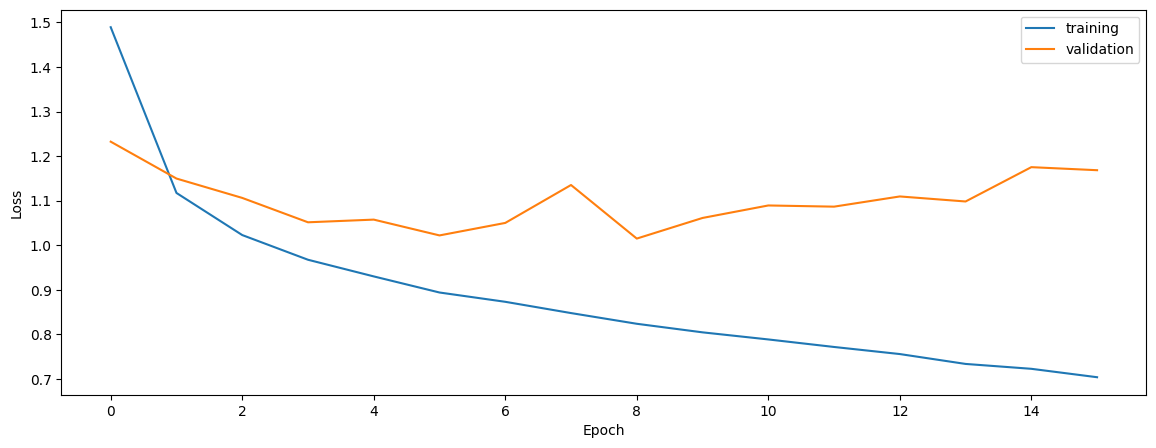

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6927194343747469
0.6166019976146925
0.6261540577930859


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.5965923315136242


0.5944987667204998
0.5127544982164052


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.597503390993296
0.5821983263439843
0.5235052077118184


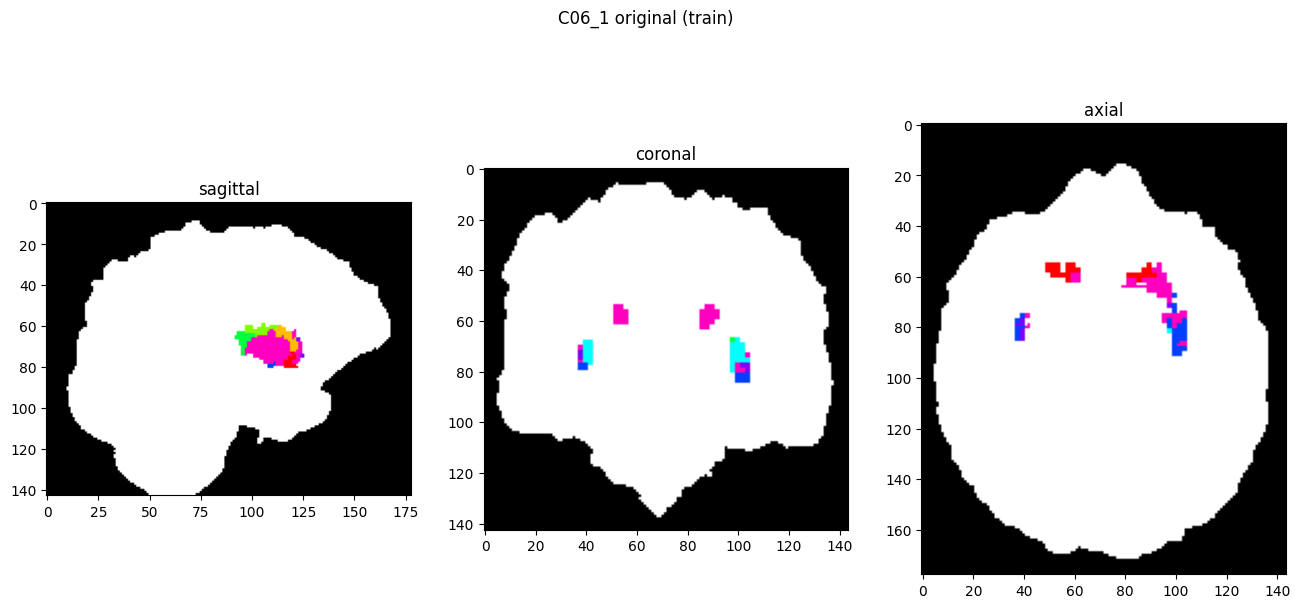

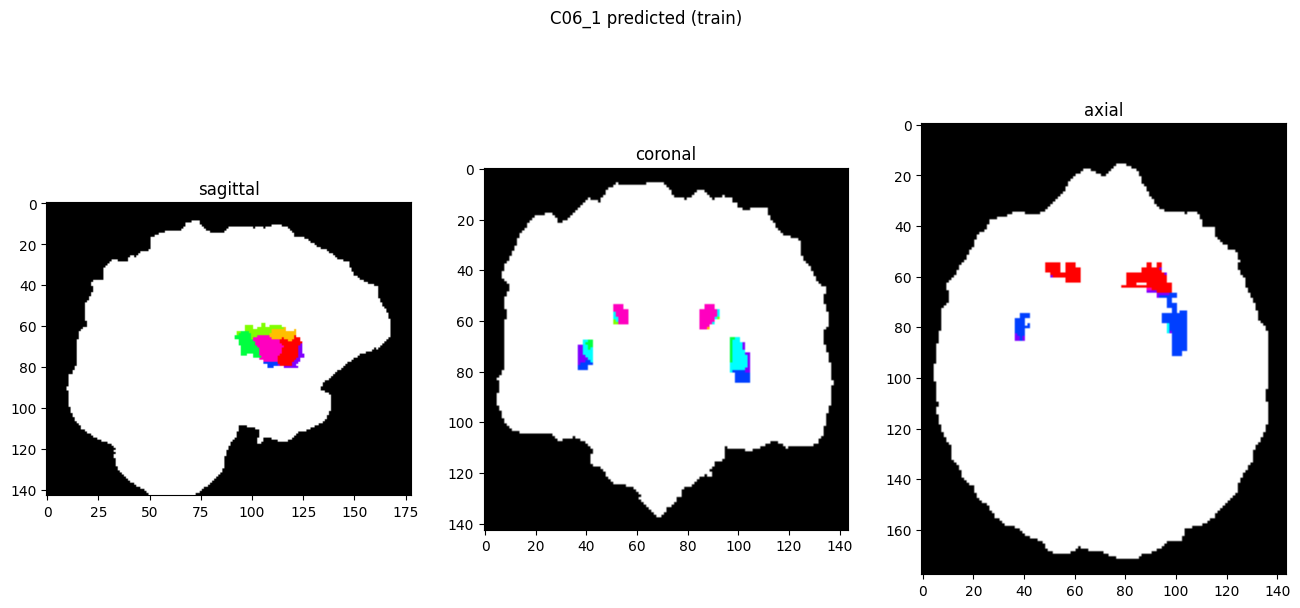

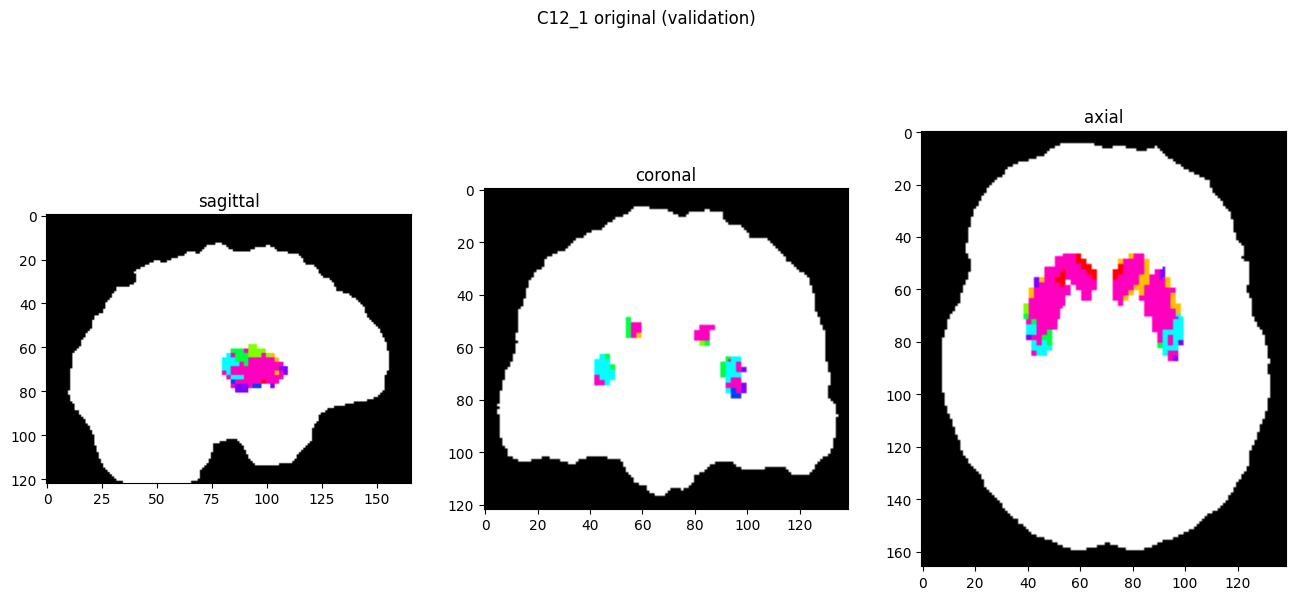

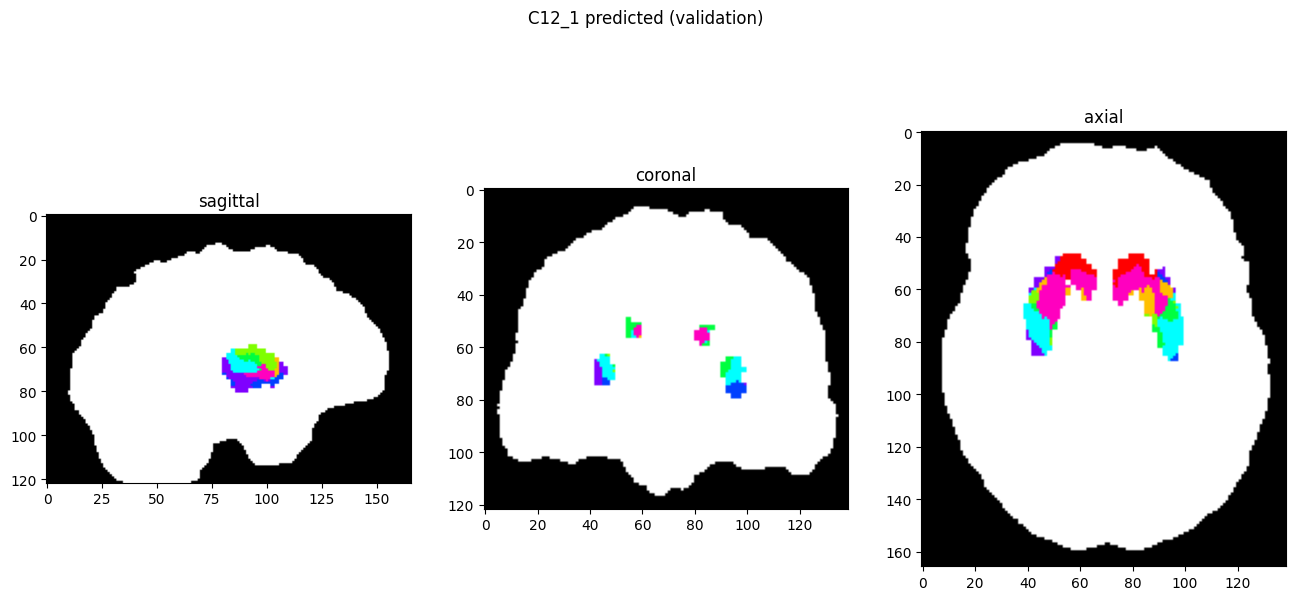

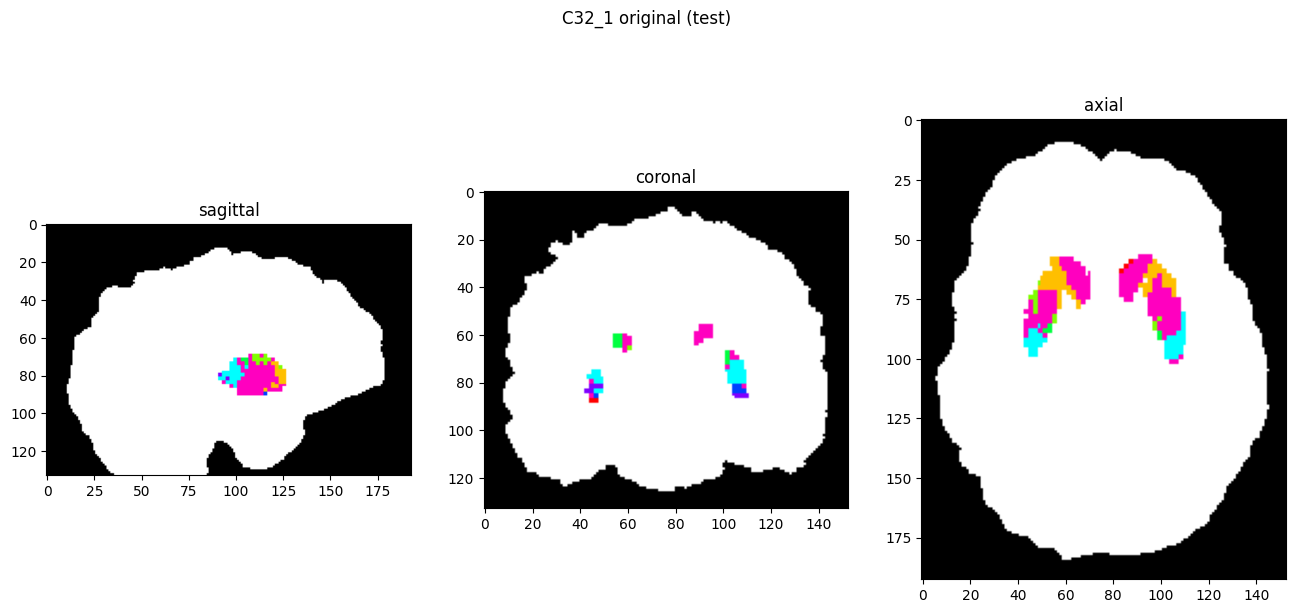

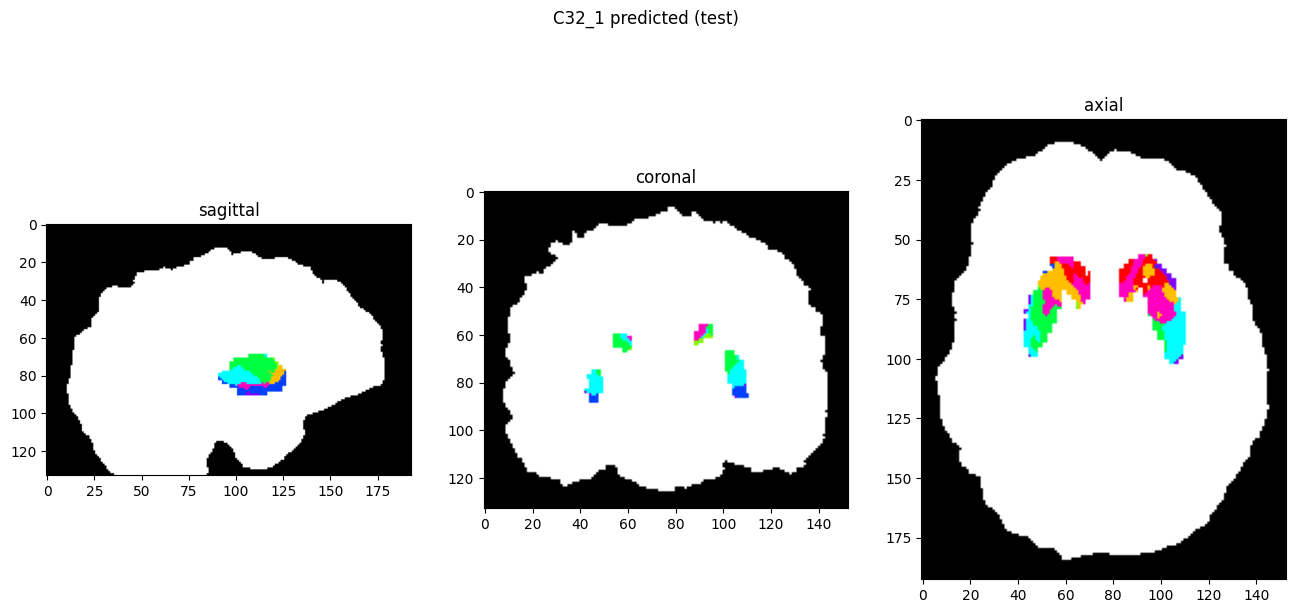

In [10]:
showResults(model, gen, threshold=0)